# Análise de Risco e Formação de Portfólios com Dados da B3 no período 2020-2024:

**Autor:** Matheus Augusto Fabri

Este notebook contém análises de risco e construções de portfólios com as ações ordinárias da B3 no quinquênio 2020-2024, sendo estas ações com o código de negociação no formato XXXX3. Estas ações, ao contrário das ações preferenciais de tipo XXXX4, permitem ao dono delas a participação de decisões empresariais. Escolhemos restringir a nossa análise somente a estas pois elas já nos fornecem um grande volume de dados e nos permitem demonstrar as técnicas aprendidas no curso *Investment Management with Python and Machine Learning* fornecido pela EDHEC Business School através da plataforma *Coursera*. O workflow deste notebook é o seguinte:

1. Começaremos com o carregamento dos dados e uma análise exploratória destes.
2. Com estes dados criaremos um índice de mercado no estilo IBOV e S&P500 que usaremos como benchmark para comparar ações específicas ou estratégias de investimento.
3. Faremos então uma análise de risco das ações, ou seja, calcularemos o retorno anualizado, a volatilidade anualizada, o drawdown máximo, índice de Sharpe, valor em risco (VaR), valor em risco condicional (CVaR), assimetria e curtose. 
4. Discutiremos então a formação de portfólios e o conceito de fronteira eficiente.
5. Analisaremos então três estratégias simples para a formação de portfólios: mistura fixa, glidepath e constant proportion portfolio insurance (CPPI).
6. Por fim encerramos com uma discussão de como aprimorar a análise aqui realizada.

Os conjunto de dados aqui utilizados foram:

- **Ações ordinárias:** conjunto de ações da B3 com código de negociação XXXX3 do período 2020-2024 retirados de [B3 Historical Quotes](https://www.b3.com.br/en_us/market-data-and-indices/data-services/market-data/historical-data/equities/historical-quotes/). Para a extração de dados usamos o script em Python dado em `script_b3_collect.py`. As informações de uso deste são dadas no arquivo ``readme_script.txt`` e com ele geramos os arquivos `ACOES_ORDINARIAS_YYYY.csv` com *YYYY* sendo um ano no período considerado. Portanto não é necessário executar `script_b3_collect.py`, pois já fornecemos todos estes arquivos juntamente com este notebook.
- **Taxa CDI:** usamos essa taxa para criar uma ativo sem risco, por exemplo podemos considerar este como um CDB que paga 100% do CDI. A taxa CDI no período 2020-2024 foi retirada de [Time Series Management System BCB](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries) e está contida no arquivo `cdi_pd_percent.csv` que fornecemos.

Ressaltamos novamente que todos os dados já foram carregados juntamente com este notebook e o usuário pode simplesmente executá-lo sem problemas.

A seguir temos as bibliotecas utilizadas neste projeto e também as suas versões:


In [1]:
import matplotlib
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import risk_module as rk

print('Versão pandas:', pd.__version__)
print('Versão numpy:', np.__version__)
print('Versão matplotlib:', matplotlib.__version__)
print('Versão seaborn:', sns.__version__)
print('Versão do scipy:', scipy.__version__)

Versão pandas: 2.2.2
Versão numpy: 1.26.4
Versão matplotlib: 3.9.2
Versão seaborn: 0.13.2
Versão do scipy: 1.13.1


O `risk_module.py` é um arquivo auxiliar contendo as funções utilizadas ao longo do projeto e usamos para ele o alias `rk`. A versão do Python utilizada é:

In [2]:
!python --version

Python 3.12.7


## Carregamento e análise exploratória de dados:

Como dito anteriormente separamos as ações ordinárias por ano em arquivos `ACOES_ORDINARIAS_YYYY.csv`. Peguemos como exemplo o ano de 2020 para ver como estes arquivos são estruturados:

In [3]:
data_2020 = pd.read_csv('./ACOES_ORDINARIAS_2020.csv', parse_dates=['DATA_DO_PREGAO'])
data_2020.head()

,DATA_DO_PREGAO,PRECO_MEDIO,CODIGO_DE_NEGOCIACAO,NOME_DA_EMPRESA,QUANTIDADE_NEGOCIADA
0,2020-01-02,18.68,AALR3,ALLIAR,585800.0
1,2020-01-02,19.12,ABEV3,AMBEV S/A,16011300.0
2,2020-01-02,2.44,ADHM3,ADVANCED-DH,193400.0
3,2020-01-02,11.15,AFLT3,AFLUENTE T,4300.0
4,2020-01-02,19.21,AGRO3,BRASILAGRO,59600.0


Vemos que o DataFrame contém a data do pregão, o preço médio do papel no dia (em R$), o código de negociação e a quantidade de ações daquele código negociada no dia. Podemos facilmente extrair uma série com os preços de cada ação e visualizar a evolução temporal. Por exemplo consideremos PETR3 da PETROBRAS:

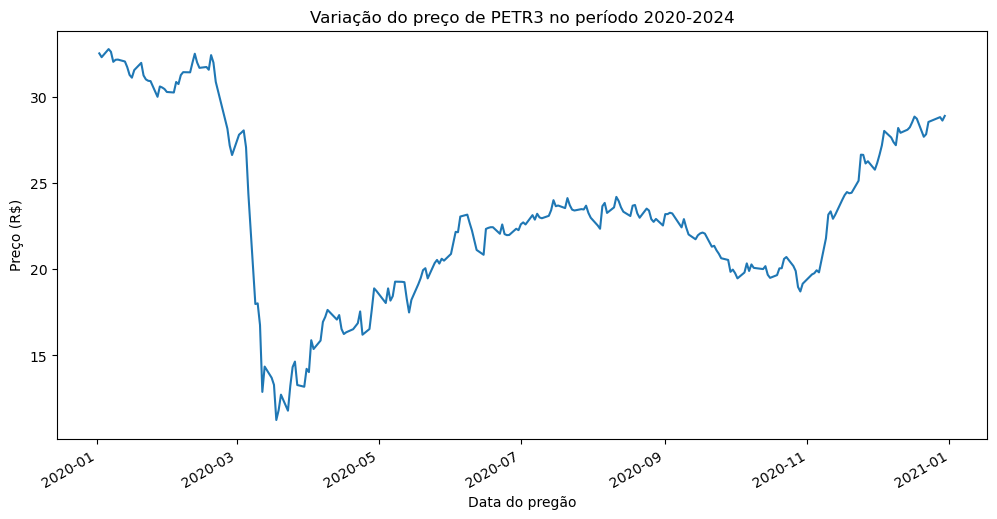

In [4]:
data_2020[data_2020['CODIGO_DE_NEGOCIACAO']=='PETR3'].plot(x='DATA_DO_PREGAO', y='PRECO_MEDIO', figsize=(12,6), legend=False, 
                                                           xlabel='Data do pregão', ylabel='Preço (R$)',
                                                           title='Variação do preço de PETR3 no período 2020-2024')
plt.show()

Note no entanto que nem todas as ações são negociadas em todos os dias de negociação como PETR3, algumas chegam a ser negociadas menos de 5 dias no ano. Exemplos disso são as ações BOBR3, CASN3 e NAFG3 da Bombril, CASAN (Companhia Catarinense de Águas e Saneamento) e Nadir Figueiredo, respectivamente. De fato, temos:

In [5]:
data_2020['CODIGO_DE_NEGOCIACAO'].value_counts(ascending=True).head(3)

CODIGO_DE_NEGOCIACAO
BOBR3    1
CASN3    2
NAFG3    3
Name: count, dtype: int64

Para simplificar a nossa análise focaremos somente em ações negociadas todos os dias de pregão (que são em torno de 250 dias no ano). Precisamos então de uma maneira de eliminar estas ações da nossa análise, para isso usamos a função auxiliar `get_data_year` do módulo `risk_module.py`, que carrega o csv respectivo de cada ano e elimina as ações que não foram negociadas todos os dias do seu respectivo ano. Com isso então montamos então um DataFrame contendo os dados dos últimos 5 anos:

In [6]:
data_5y = pd.concat([rk.get_data_year(year) for year in range(2020,2024 + 1)])

Podemos então ver o fim deste DataFrame:

In [7]:
data_5y.tail()

,DATA_DO_PREGAO,PRECO_MEDIO,CODIGO_DE_NEGOCIACAO,NOME_DA_EMPRESA,QUANTIDADE_NEGOCIADA,VOLUME
67284,2024-12-30,2.58,RSID3,ROSSI RESID,115600.0,298248.0
67285,2024-12-30,6.69,AMER3,AMERICANAS,9595200.0,64191888.0
67286,2024-12-30,1.14,ATMP3,ATMASA,11100.0,12654.0
67287,2024-12-30,0.45,AGXY3,AGROGALAXY,280600.0,126270.0
67288,2024-12-30,3.83,NEXP3,NEXPE,1400.0,5362.0


Note a inclusão da coluna VOLUME que é a quantidade de ações negociadas no dia multiplicada pelo preço, isto é, o volume de negociação no dia. Esta informação será útil mais tarde para construirmos um índice de mercado que servirá como benchmark das estratégias de investimento a serem discutidas. Com a função `get_df` podemos construir dois DataFrames, um com colunas contendo a série temporal do preço de cada ação e outro com as séries temporais dos volumes sendo os dois indexados pela data do pregão:

In [8]:
prices_5y = rk.get_df(data_5y, 'PRECO_MEDIO')
vol_5y = rk.get_df(data_5y, 'VOLUME')

Com isso podemos ver o range de datas de cada DataFrame e o quantas ações cada um contém:

In [9]:
prices_5y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2020-01-02 to 2024-12-30
Columns: 129 entries, AALR3 to VIVR3
dtypes: float64(129)
memory usage: 1.2 MB


In [10]:
vol_5y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2020-01-02 to 2024-12-30
Columns: 129 entries, AALR3 to VIVR3
dtypes: float64(129)
memory usage: 1.2 MB


Temos que o período coberto nestes DataFrames vão de 02 de Janeiro de 2020 até 30 de Dezembro de 2024 e como esperado ambos possuem o mesmo número de ações (129). O formato destes são:

In [11]:
prices_5y.iloc[:5,:5]

,AALR3,ABEV3,AGRO3,ALUP3,AMAR3
DATA_DO_PREGAO,,,,,
2020-01-02,18.68,19.12,19.21,11.15,13.34
2020-01-03,18.95,19.00,19.23,11.38,13.62
2020-01-06,18.97,19.01,19.36,11.36,13.68
2020-01-07,18.95,19.04,19.46,11.32,13.75
2020-01-08,18.96,19.01,19.46,11.42,13.86


In [12]:
vol_5y.iloc[:5,:5]

,AALR3,ABEV3,AGRO3,ALUP3,AMAR3
DATA_DO_PREGAO,,,,,
2020-01-02,10942744.0,306136056.0,1144916.0,631090.0,22240448.0
2020-01-03,11411690.0,381121000.0,763431.0,109248.0,26474556.0
2020-01-06,7844095.0,278388143.0,857648.0,57936.0,17919432.0
2020-01-07,1824885.0,343416864.0,776454.0,218476.0,18427750.0
2020-01-08,5356200.0,267122817.0,527366.0,497912.0,21417858.0


Vejamos a evolução temporal de por exemplo PETR3, CPLE3, MGLU3 e ITSA3:

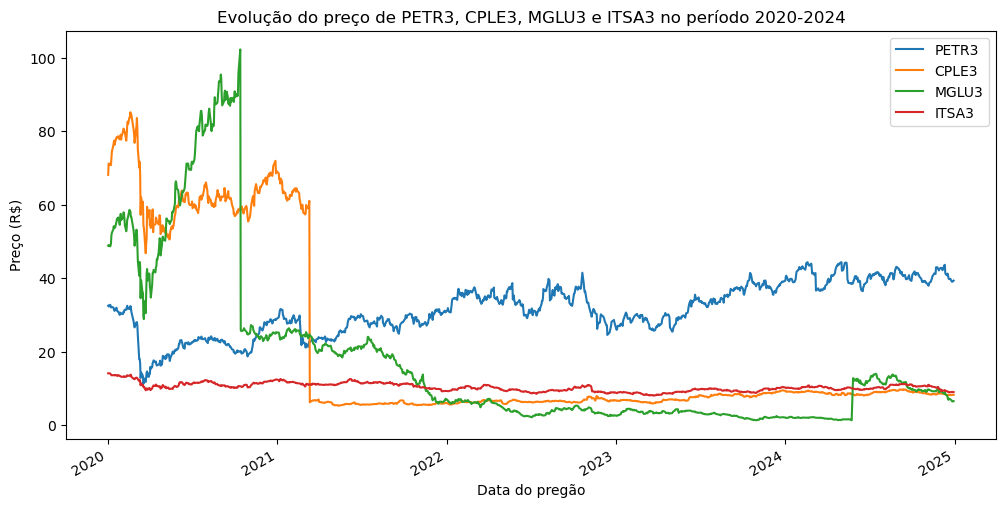

In [13]:
prices_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']].plot(figsize=(12,6), 
                                                     xlabel='Data do pregão', ylabel='Preço (R$)',
                                                     title='Evolução do preço de PETR3, CPLE3, MGLU3 e ITSA3 no período 2020-2024')
plt.show()

De maneira similar vejamos a evolução temporal do volume negociado de PETR3 e MGLU3:

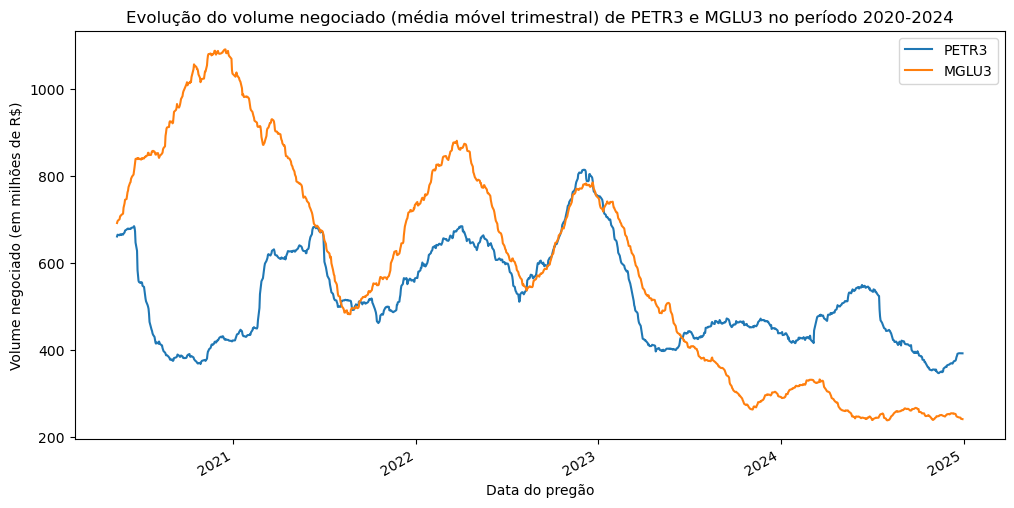

In [14]:
vol_5y[['PETR3','MGLU3']].divide(1e6).rolling(90).mean().plot(figsize=(12,6), 
                                                     xlabel='Data do pregão', ylabel='Volume negociado (em milhões de R$)',
                                                     title='Evolução do volume negociado (média móvel trimestral) de PETR3 e MGLU3 no período 2020-2024')
plt.show()

Neste caso para melhor visualização pegamos uma média móvel trimestral do volume da ação. Por conveniência salvemos estes dois Dataframes:

In [15]:
prices_5y.to_csv('./prices_5y_b3.csv')
vol_5y.to_csv('./vol_5y_b3.csv')

Para a nossa análise o preço em si não é relevante, mas sim os retornos diários. Para isso definimos:

In [16]:
rets_5y = prices_5y.pct_change().fillna(0)
rets_5y.to_csv('./rets_5y_b3.csv')

Aonde adicionamos retorno nulo no primeiro dia. Usando a função `compound` de nosso módulo podemos calcular o patrimônio acumulado de cada ação por real investido. Por exemplo para PETR3, CPLE3, MGLU3 e ITSA3:

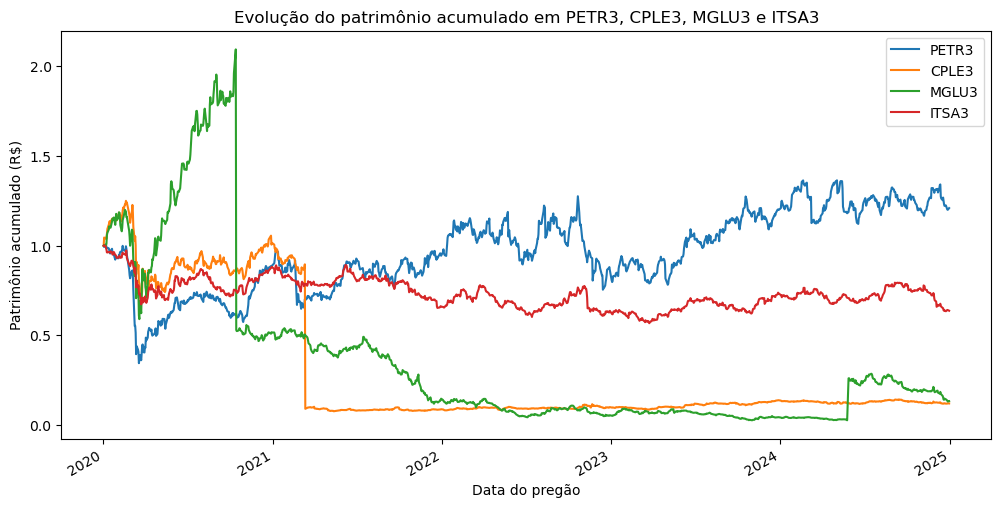

In [17]:
rk.compound(rets_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']]).plot(figsize=(12,6),
                                                                xlabel='Data do pregão', ylabel='Patrimônio acumulado (R$)',
                                                                title='Evolução do patrimônio acumulado em PETR3, CPLE3, MGLU3 e ITSA3')
plt.show()

Discutiremos o retorno e características das ações nas seções a seguir. Para fins de comparação e construção de portfólios precisamos de um investimento sem risco. Para isso usaremos a taxa diária CDI, isto é, consideraremos como sem risco um investimento que paga 100% do CDI. Carregamos o CDI usando a função `get_risk_free` de nosso módulo:

In [18]:
rets_sav = rk.get_risk_free()

Logo o patrimônio acumulado a cada real investido é:

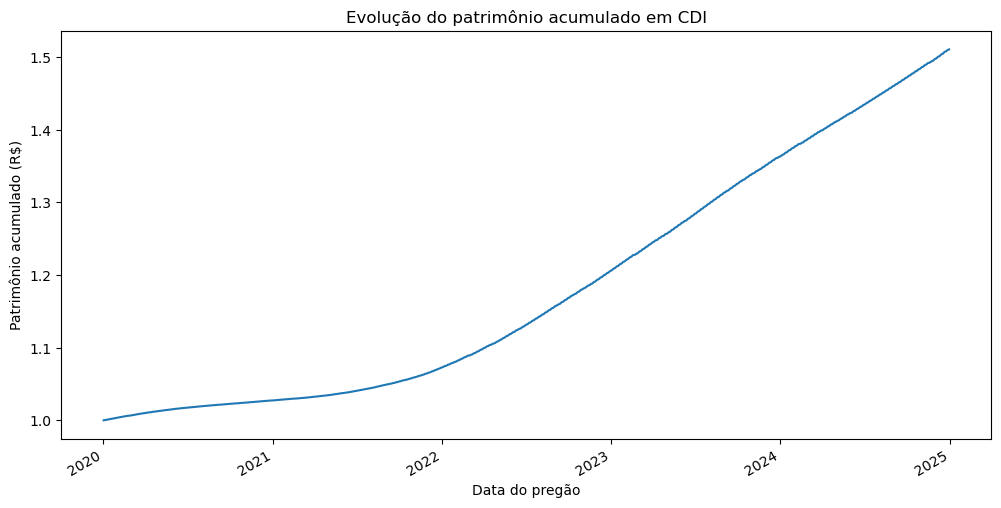

In [19]:
rk.compound(rets_sav).plot(figsize=(12,6), title='Evolução do patrimônio acumulado em CDI', 
                                               xlabel='Data do pregão', ylabel='Patrimônio acumulado (R$)')
plt.show()

Esse investimento não é necessariamente sem risco dado que a taxa varia diariamente e portanto há uma volatilidade (baixa porém não nula) e ainda há o risco baixo do título não ser pago ao dono (geralmente risco baixíssimo). A variação do CDI pode ser visto abaixo:

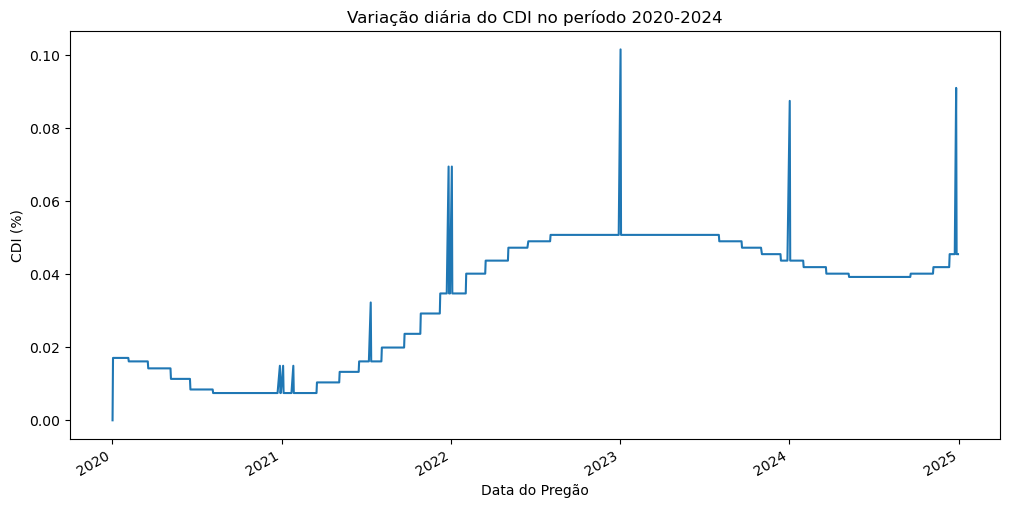

In [20]:
rets_sav.multiply(100).plot(figsize=(12,6), 
                            title='Variação diária do CDI no período 2020-2024', 
                            xlabel='Data do Pregão', ylabel='CDI (%)')
plt.show()

Os picos advém do fato de que o CDI é atualizado diaramente enquanto a bolsa funciona somente em dias utéis, logo os picos representam o retorno acumulado no período que o pregão estava fechado (o que explica a presença destes ao redor do fim e ínicio de ano).

## Criação de índice de mercado:

Criemos agora um índice de mercado, isto é, um conjunto de retornos que podemos usar como benchmark para compararmos com estratégias de construção de portfólios. Vamos criar o índice de mercado aqui de maneira análoga ao IBOV ou ao S&P500, isto é, uma média ponderada em volume de mercado. Neste índices outros fatores entram nas ações que compõem a carteira hipotética. No caso do IBOV temos que 84 ações compõem o índice, no nosso caso usaremos 80 ações das 129 disponíveis em nosso DataFrame.

Seja $R_i$ e $V_i$ o retorno e o volume de uma ação que compõe o nosso índice, definimos o peso $w_i$ desta ação na carteira como:
$$
w_i = \frac{V_i}{\sum_{i=1}^{80} V_i}
$$
Logo $w_1 + w_2 + \cdots + w_{80} = 1$ e o retorno composto de nosso índice é:
$$
R_{IS} = \sum_{i=1}^{80} w_i R_i
$$
Aonde IS (Índice Simulado) é o nome de nosso índice. Para escolher as ações que o compõe usaremos as 80 ações com maior média mensal de volume. Para isso usamos o seguinte código:

In [21]:
# calcula o volume mensal médio de cada ação
vol_m_5y = vol_5y.resample('ME').apply('sum').mean(axis='rows')
# extrai as 80 ações com maiors volumes mensais médios
stocks_IS = vol_m_5y.sort_values(ascending=False).head(80).index

Aonde primeiro fazemos um agrupamento (`resample`) por mês dos volumes e somamos o volume em cada mês para obter o volume total por mês em 5 anos. Então fazemos uma média do volume mensal (`mean(axis='rows')`) e pegamos as 80 ações com maiores volumes mensais médios. As 10 primeiras ações são:

In [22]:
list(stocks_IS)[:10]

['VALE3',
 'MGLU3',
 'BBAS3',
 'PETR3',
 'RENT3',
 'ABEV3',
 'PRIO3',
 'SUZB3',
 'LREN3',
 'ELET3']

Logo calculamos o peso de cada uma dessas ações usando a formula dada anteriormente e o retorno conjunto do índice:

In [23]:
# pesos de IS
w_IS = vol_5y[stocks_IS].divide(vol_5y[stocks_IS].sum(axis='columns'), axis='rows')
# retorno da carteira agregada
rets_IS = (w_IS*rets_5y[stocks_IS]).sum(axis='columns')
rets_IS.name = 'IS'

Podemos ver então os pesos das dez ações que mais contribuem para IS na média no período de 2020-2024:

In [24]:
w_IS.mean().sort_values(ascending=False).multiply(100)[:10]

VALE3    16.508786
MGLU3     4.756805
BBAS3     4.540201
PETR3     4.273575
RENT3     3.307722
PRIO3     3.286622
ABEV3     3.261755
SUZB3     3.047915
LREN3     2.812600
ELET3     2.599574
dtype: float64

Note que estes são os pesos médios, dado que os pesos são reajustados diaramente baseado no volume de transação. Vemos que uma parte majoritária da carteira é composta de VALE3 (~16.51%) com o restante das ações tendo uma participação menor a 5%. A ação com menor participação é FHER3 (~0.098%). Um teste para vermos se a construção da carteira é correta é a verificação que os pesos em cada pregão somam no total 1:

In [25]:
((w_IS.sum(axis='columns')-1)**2).sum()

8.999177295341574e-29

Com isso feito podemos comparar o patrimônio acumulado do IS com ações específicas, no caso usaremos VALE3, MGLU3, BBAS3 e PETR3 que são as quatro ações majoritárias em nossa carteira:

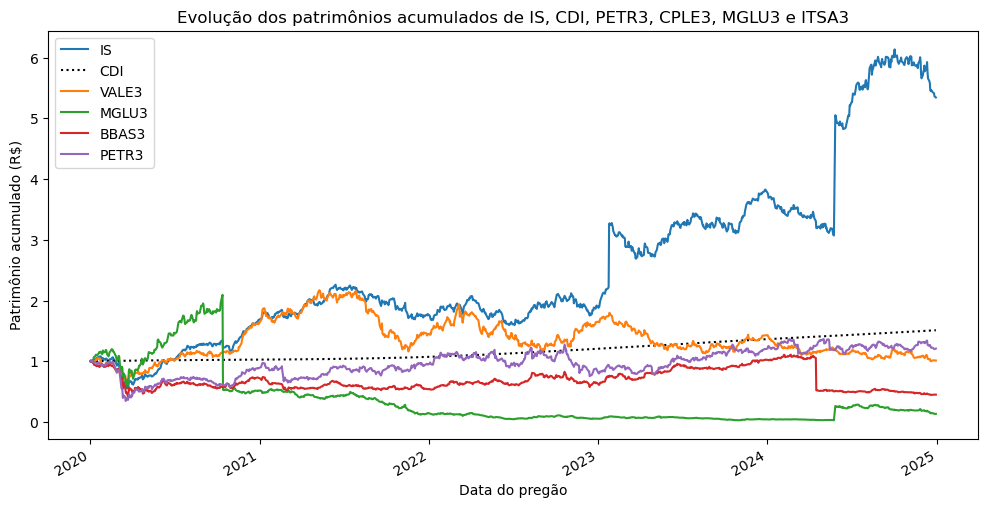

In [26]:
# plot IS
ax = rk.compound(rets_IS).plot(figsize=(12,6), label='IS')
# plot CDI
rk.compound(rets_sav).plot(label='CDI', style=':k')
# plot ações
rk.compound(rets_5y[['VALE3', 'MGLU3', 'BBAS3', 'PETR3']]).plot(ax=ax)
# plot info
plt.title('Evolução dos patrimônios acumulados de IS, CDI, PETR3, CPLE3, MGLU3 e ITSA3')
plt.xlabel('Data do pregão')
plt.ylabel('Patrimônio acumulado (R$)')
plt.legend()
plt.show()

Vemos que o CDI rende mais a longo prazo que todas as ações individuais consideradas, no entanto uma combinação por volume de mercado como o IS chega a render aproximadamente 434.66% comparado ao rendimento do CDI que foi de 51.06%.

## Análise de risco:

Façamos agora uma breve análise de risco. Para realizá-la vamos considerar quantidades anualizadas, logo precisamos da quantidade de períodos (dias de negociação) por ano. Essa quantidade varia cada ano, então façamos uma média no período dado. O código abaixo nos dá essa média:

In [27]:
# calcula o número de pregões por ano e faz a média
n_dates = np.array([rets_5y[str(year):str(year)].shape[0] for year in range(2020, 2024+1)]).mean()
n_dates

249.0

Vemos que em media temos 249 dias de negociação. Com isso seguiremos agora para a nossa análise.

### Drawdown:

Agora nós calcularemos o dradown. Dado um patrimônio inicial alocado em uma ação podemos calcular a evolução do patrimônio acumulado e compará-lo com o pico histórico de patrimônio. A diferença percentual entre essas curvas é chamada curva de drawdown e conceitualmente nada mais é que a perda percentual de patrimônio em relação ao maior pico histórico. O cálculo do drawdown é realizado por meio da função `drawdown` e esta recebe uma Series de retornos (e opcionalmente um patrimônio inicial) e retorna um DataFrame com o patrimônio acumulado, a série histórica de maiores picos e a curva de drawdown. Como exemplo consideremos MGLU3:

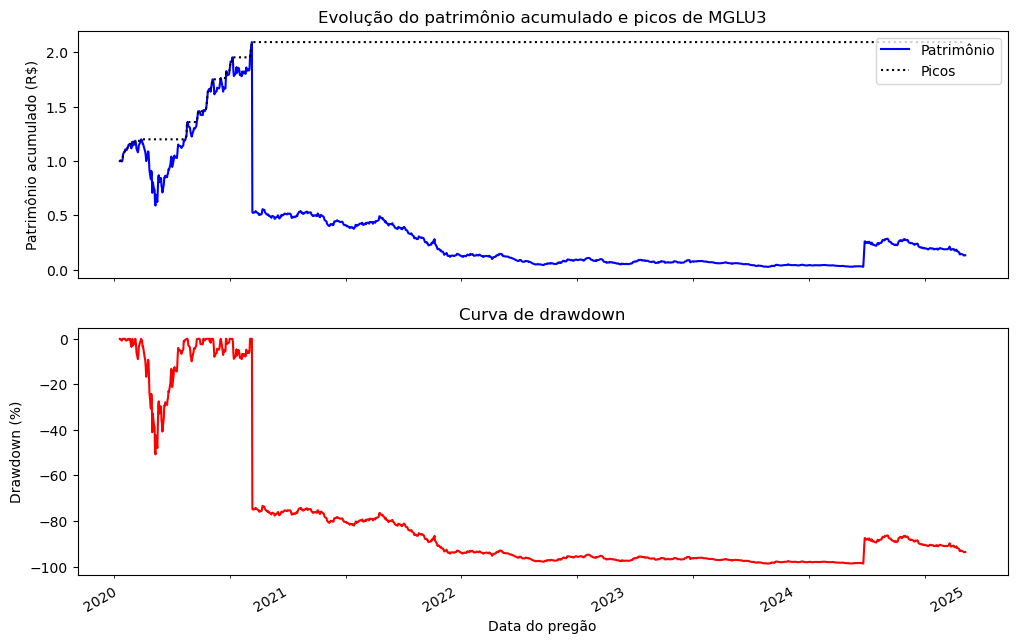

In [28]:
# cálculo do drawdown
DD_ex = rk.drawdown(rets_5y['MGLU3'])
# criação dos eixos
fig, ax = plt.subplots(2, sharex=True, figsize=(12,8))
# plot patrimônio e picos
DD_ex[['Wealth', 'Peaks']].plot(ax=ax[0], title='Evolução do patrimônio acumulado e picos de MGLU3', 
                                ylabel='Patrimônio acumulado (R$)', style=['blue', ':k'])
ax[0].legend(['Patrimônio', 'Picos'], loc=1)
ax[0].tick_params(bottom=False)
# plot drawdown
DD_ex.multiply(100)['Drawdowns'].plot(ax=ax[1], title='Curva de drawdown', c='red',
                                      xlabel='Data do pregão', ylabel='Drawdown (%)', legend=False)
ax[1].tick_params(bottom=False)

plt.show()

Vemos um drawdown significativo para MGLU3, de fato temos um drawdown máximo de -98.7% que ocorreu em 1 de Novembro de 2023:

In [29]:
DD_ex['Drawdowns'].min()*100, DD_ex['Drawdowns'].idxmin()

(-98.69939370232741, Timestamp('2023-11-01 00:00:00'))

Já para o caso do nosso IS temos um drawdown bem menor, de fato:

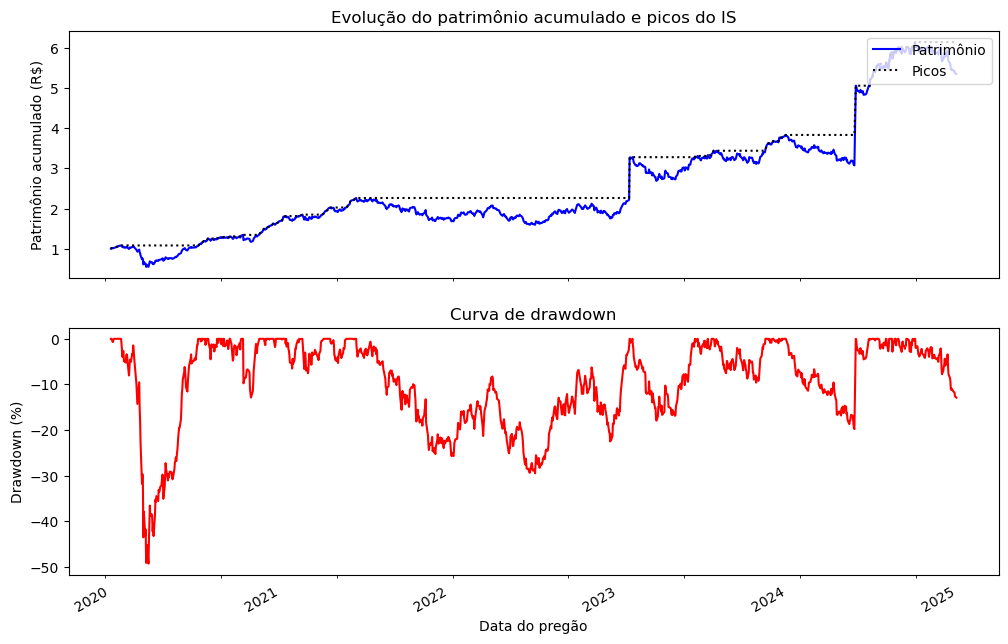

In [30]:
# cálculo do drawdown
DD_ex = rk.drawdown(rets_IS)
# criação dos eixos
fig, ax = plt.subplots(2, sharex=True, figsize=(12,8))
# plot patrimônio e picos
DD_ex[['Wealth', 'Peaks']].plot(ax=ax[0], title='Evolução do patrimônio acumulado e picos do IS', 
                                ylabel='Patrimônio acumulado (R$)', style=['blue', ':k'])
ax[0].legend(['Patrimônio', 'Picos'], loc=1)
ax[0].tick_params(bottom=False)
# plot drawdown
DD_ex.multiply(100)['Drawdowns'].plot(ax=ax[1], title='Curva de drawdown', c='red',
                                      xlabel='Data do pregão', ylabel='Drawdown (%)', legend=False)
ax[1].tick_params(bottom=False)

plt.show()

Vemos que apesar de um grande drawdown em 2020 a curva de drawdown se mantém relativamente perto de 0 (maior que -30%) o que sinaliza o crescimento do índice, como mostrado na evolução do patrimônio. Aqui temos um drawdown máximo de -49.26% em 23 de Março de 2020:

In [31]:
DD_ex['Drawdowns'].min()*100, DD_ex['Drawdowns'].idxmin()

(-49.25837219644197, Timestamp('2020-03-23 00:00:00'))

### Retorno e volatilidades anualizadas:

O retorno anualizado $\bar{R}_{anual}$ é simples de ser cálculado e é dado pela expressão:
$$
1+\bar{R}_{anual} = \left(\prod_{i=1}^{N_{days}}(1+R_i)\right)^{N_{periods}/N_{days}}
$$
com $N_{days}$ sendo o número de dias considerados e $N_{periods}$ o número de períodos no ano, neste caso $N_{periods}=249$ como calculado anteriormente. O retorno anualizado é calculado pela função `annualized_rets`. Já a volatilidade anualizada é calculada por meio de:
$$
\bar{\sigma}_{anual} = \sqrt{N_{periods}} \ \sigma_T 
$$
Com $\sigma_T$ sendo a volatidade (desvio padrão) histórico. Para MGLU3 o retorno anualizado é de -33.11% como dado abaixo:

In [32]:
rk.annualized_rets(rets_5y['MGLU3'], periods_per_year=n_dates)*100

-33.10738024620581

Já a volatilidade anual é altissíma e é aproximadamente 386.65%:

In [33]:
rk.annualized_vol(rets_5y['MGLU3'], periods_per_year=n_dates)*100

386.6454181595796

### Índice de Sharpe:

O índice de Sharpe (SR) é nada mais que o retorno anualizado em excesso, em relação a um ativo sem risco, dividido pela volatilidade anualizada. Logo é dado por:
$$
SR = \frac{(R - R^{(f)})_{anual}}{\bar{\sigma}_{anual}}
$$
Aonde $(R - R^{(f)})_{anual}$ é o retorno em excesso anualizado, isto é, o retorno da ação menos o retorno do ativo sem risco anualizado. O índice de Sharpe se positivo (negativo) nos indica o quão melhor (pior) que a ação se comporta em relação ao ativo sem risco. Já SRs altos (baixos) nos indicam uma baixa (alta) volatidade e portanto uma maior (menor) previsibilidade. Portanto os melhores ativos teriam SR alto e positivo. Nós implementamos SR com a função `sharpe_ratio` e no caso da MGLU3 temos que:

In [34]:
rk.sharpe_ratio(rets_5y['MGLU3'], rets_sav, n_dates)

-0.09938020911802216

O que indica que o retorno de MGLU3 é menor que o nosso ativo sem risco (CDI) e a ação possui uma alta volatilidade. Consideremos agora a ação EMBR3 com índice de Sharpe positivo:

In [35]:
rk.sharpe_ratio(rets_5y['EMBR3'], rets_sav, n_dates)

0.28466609472064097

Como SR é positivo temos um retorno maior que o CDI e além disso uma baixa volatilidade (em relação a MGLU3) dada a sua magnitude. De fato a volatilidade anualizada de EMBR3 é de 46%:

In [36]:
rk.annualized_vol(rets_5y['EMBR3'], n_dates)*100

45.99115808395006

### Assimetria, curtose e desvios da normalidade:

Os retornos em si são aleatórios e podemos nos perguntar o quão distante estes são da distribuição normal. Duas medidas para estimar o desvio da normalidade são a assimetria e a curtose. Basicamente a assimetria (skewness) e a curtose (kurtosis) medem o desvio cúbico e quártico em relação a média, respectivamente. Logo dado uma série de retornos $R$ com média $\bar{R}$, a assimetria é definida como:
$$ 
S(R) = \frac{\mathbb{E}[(R-\bar{R})^3]}{\sigma_R^3} 
$$
A interpretação é que uma assimetria positiva (negativa) indica uma distribuição assimétrica a esquerda (direita) em relação a média. É fácil ver que a distribuição normal possui assimetria nula e portanto a presença desta indica um desvio da normalidade. Já a curtose é definida como:
$$ 
K(R) = \frac{\mathbb{E}[(R-\bar{R})^4]}{\sigma_R^4} 
$$
Esta é uma medida do achatamento da distribuição em relação a distribuição normal, como a distribuição normal possui $K=3$ temos que $K-3$ é denominado excesso de curtose e indica um desvio da normalidade. Estas são implementadas por `skewness` e `kurtosis`. Logo para a assimetria temos: 

In [37]:
rk.skewness(rets_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']])

PETR3    -1.945918
CPLE3   -17.399458
MGLU3    33.582024
ITSA3    -0.546865
dtype: float64

O que indica um desvio considerável da normalidade, isto é acentuado pela curtose:

In [38]:
rk.kurtosis(rets_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']])

PETR3      20.695023
CPLE3     491.540811
MGLU3    1166.700791
ITSA3       7.717967
dtype: float64

O desvio fica mais claro quando comparamos com uma distribuição normal dado o retorno médio e desvio padrão. De fato para MGLU3 podemos fazer uma estimativa de densidade de kernel (kde) e temos:

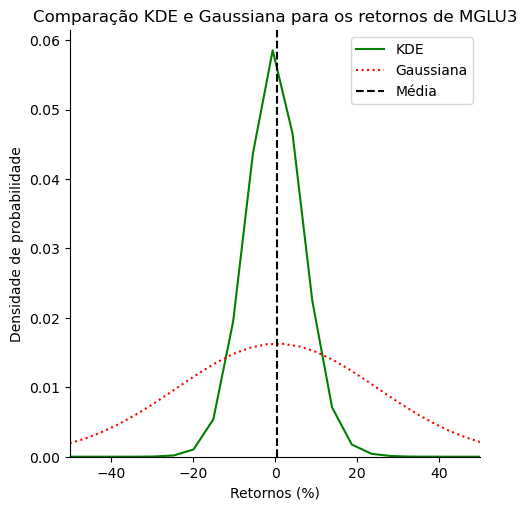

In [39]:
data_ex = rets_5y['MGLU3']*100

# kde para retornos
sns.displot(data_ex, kind='kde', color='green', label='KDE')
plt.xlim(-50, 50)
# gaussiana 
gaussian = scipy.stats.norm(loc=data_ex.mean(), scale=data_ex.std())
xs = np.linspace(-200, 200, 100)
ys = gaussian.pdf(xs)
plt.plot(xs, ys, linestyle=':', c='red', label='Gaussiana')
# média
plt.axvline(x=data_ex.mean(), linestyle='--', c='black', label='Média')

plt.title('Comparação KDE e Gaussiana para os retornos de MGLU3')
plt.xlabel('Retornos (%)')
plt.ylabel('Densidade de probabilidade')
plt.legend(loc=1)
plt.show()

Vemos claramente o desvio da normalidade. Note que MGLU3 tem uma assimetria positiva e portanto uma assimetria à esquerda e um grande achatamento em torno da média devido a alta curtose.

### Valor em risco (VaR) e valor em risco condicional (CVaR):

O valor em risco (VaR) é o limite máximo de potencial perda dado um nível de confiabilidade em um dado intervalo de tempo. Como exemplo considere uma probabilidade de 5%, o VaR é o retorno limite que nos daria esta probabilidade de 5%. Mais precisamente, dado um nível de confiabilidade $p$ e a probabilidade $\mathbb{P}$ para os retornos, o VaR de retornos $R_{VaR}$ é definido como: 
$$
\mathbb{P}(R\leq R_{VaR}) = p
$$
Vamos estimar o VaR de três maneiras:

- Historic VaR histórico
- VaR gaussiano
- Expansão de Cornish-Fisher

O VaR histórico assume nenhuma hipótese acerca dos dados e é baseado puramente em dados históricos, i.e., VaR histórico nada mais é que o percentil. Implementamos com `var_historic` e para um nível de 5% temos:

In [40]:
rk.var_historic(rets_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']], p=5)*100

PETR3   -3.521607
CPLE3   -2.470710
MGLU3   -5.974098
ITSA3   -1.965266
dtype: float64

O que significa que puramente baseado na série histórica temos com 5% de probabilidade que PETR3, CPEL3, MGLU3 e ITSA3 teriam retornos máximos de -3.52%, -2.47%, -5.97% e -1.97%, respectivamente. Note que em nossa implementação VaR mantém o sinal original do retorno. 

Já o VaR gaussiano assume que a data tem uma distribuição normal. Claramente isso não é o caso dada a discussão da seção anterior, contudo serve como uma primeira aproximação. Para calcular o VaR gaussiano dado um percentil $p$ usamos que:
$$
\mathbb{P}\left(\frac{R - \bar{R}}{\sigma_{R}}\leq z_{p}\right) = p \leftrightarrow \mathbb{P}\left(R_p \leq \bar{R} + z_{p} \ \sigma_{R} \right) = p
$$
Com $\bar{R}$ sendo o retorno médio e $z_{p}$ sendo o percentil da distribuição normal (média nula e variância unitária). Logo $R_{VaR}$ é dado por
$$
R_{VaR} = \bar{R} + z_{p}\ \sigma_R
$$
Com $z_{p}$ sendo calculado numéricamente. Implementamos VaR gaussiano com `var_gaussian` e para um intervalo de confiança de 5% temos:

In [41]:
rk.var_gaussian(rets_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']], p=5)*100

PETR3    -4.376282
CPLE3    -5.326779
MGLU3   -39.824701
ITSA3    -2.232922
dtype: float64

Para essas ações temos um VaR parecido com o da série histórica, contudo para MGLU3 temos uma considerável diferença em relação ao VaR histórico. Isso pode explicado pelo fato de que MGLU3 não possui uma distribuição Gaussiana dada a sual assimetria e alta curtose como na seção anterior.

Por fim temos a expansão de Cornish-Fisher para o VaR. Esta basicamente uma distribuição genérica para os retornos como uma perturbação de uma distribuição Gaussiana. Neste caso temos que dado um intervalo de confiança $p$ então:
$$
R_{VaR} =  \bar{R} + \tilde{z}_{p}\ \sigma_{R}
$$
Aonde $\tilde{z}_{p}$ é dado por uma expansão ao redor do VaR Gaussiano $z_{p}$:
$$
\tilde{z}_{p} = z_{p} + \frac{(z_{p}^2 - 1)}{6}\ S(R) + \frac{(z_{p}^3 - 3 z_{p})}{24}\ (K(R)-3) - \frac{(2z_{p}^3 - 5z_{p})}{36}\ S(R)^2
$$
Claramente esta expansão só tem sentido se $S(R)$ e $K(R)-3$ são razoalvemente baixos, caso contrário a expansão diverge. Implementamos o Cornish-Fisher VaR com `var_gaussian` agora com o kwarg `modified=True` e para o nosso exemplo com 5% de intervalo de confiança encontramos que:

In [42]:
rk.var_gaussian(rets_5y[['PETR3', 'CPLE3', 'MGLU3', 'ITSA3']], p=5, modified=True)*100

PETR3      -4.712676
CPLE3      28.748120
MGLU3    1287.992940
ITSA3      -2.306173
dtype: float64

A alta disparidade com o VaR histórico pode ser novamente explicado devido a alta assimetria e curtose, o que invalidaria a expansão. Por fim enceramos a discussão do VaR mostrando as dez ações com os menores VaR históricos (em %) assumindo um intervalo de confiança de 5%:

In [43]:
rk.var_historic(rets_5y, p=5).sort_values().multiply(100).round(2).head(10)

RCSL3   -8.81
PDGR3   -8.02
OIBR3   -6.70
CVCB3   -6.23
GFSA3   -6.10
MGLU3   -5.97
VIVR3   -5.88
LUPA3   -5.71
ANIM3   -5.64
IRBR3   -5.52
dtype: float64

Logo existem ações (RCSL3 e PDGR3) tal que com 5% de chance pode-se obter retornos abaixos de -8%. Discutamos agora um conceito relacionado que é o valor em risco condicional (CVaR), este nada mais é a perda esperada média para retornos abaixo do VaR. Logo é definido em termos do seguinte valor esperado condicionado:
$$
\bar{R}_{CVaR} = \mathbb{E}( R | R \leq R_{VaR} ).
$$
Nós implementamos o CVaR com `cvar` e com a kwarg `var_estimator` podemos escolher entre as três maneiras de estimar o VaR descritas acima. Com isso podemos calcula as dez maiores CVaR (em %) com um intervalo de confiança de 5% usando o VaR histórico:

In [44]:
rk.cvar(r=rets_5y, var_estimator = rk.var_historic, p=5).multiply(100).sort_values().round(2).head(10)

PDGR3   -13.97
RCSL3   -12.68
OIBR3   -11.63
GFSA3    -9.97
CVCB3    -9.29
IRBR3    -9.28
FHER3    -9.24
ANIM3    -9.22
MGLU3    -9.21
VIVR3    -9.16
dtype: float64

Chegamos a ter perdas médias de até 13.97% com 5% de probabilidade! Já usando VaR Gaussiano:

In [45]:
rk.cvar(r=rets_5y, var_estimator=rk.var_gaussian, p=5, modified=False).multiply(100).sort_values().round(2).head(10)

MGLU3   -74.65
OIBR3   -65.49
AMAR3   -26.41
RCSL3   -25.60
HBOR3   -22.87
TPIS3   -18.00
PRIO3   -15.49
HAPV3   -15.23
CPLE3   -14.85
RADL3   -14.79
dtype: float64

A disparidade é novamente explicada devido a não-Gaussianidade dos retornos. E por fim usando o Cornish-Fisher VaR encontramos:

In [46]:
rk.cvar(r=rets_5y, var_estimator=rk.var_gaussian, p=5, modified=True).multiply(100).sort_values().round(2).head(10)

CVCB3   -10.03
CEAB3    -9.24
MEAL3    -9.19
PETR3    -9.11
AALR3    -8.72
POSI3    -8.58
TRIS3    -8.48
ETER3    -8.30
ANIM3    -8.30
NTCO3    -8.25
dtype: float64

O que nos dá estimativas mais sensíveis de CVaR.

### Estatísticas agregadas:

Agora agregamos as estatísticas das seções anteriores com a função `summary_stats`, esta recebe um DataFrame de retornos, número de períodos e retornos de um ativo sem risco e devolve o retorno e volatilidade anualizados, SR, drawdown máximo, assimetria, curtose, VaR e CVaR históricos. Logo calculemos estas estatísticas para os retornos dos ultimos 5 anos, para o CDI e o nosso índice:

In [47]:
rets_5y_stats = rk.summary_stats(rets_5y, n_dates, rets_sav)
IS_stats = rk.summary_stats(rets_IS, n_dates, rets_sav)
CDI_stats = rk.summary_stats(rets_sav, n_dates, rets_sav)

Logo para os retornos dos últimos 5 anos temos:

In [48]:
rets_5y_stats.head(10)

,Retorno Anualizado (%),Volatilidade Anualizada (%),SR Anualizado,Drawdown Máximo (%),Assimetria,Curtose,VaR Histórico (%),CVaR Histórico (%)
AALR3,-14.91,49.04,-0.44,-74.00,-0.16,10.35,-4.40,-7.80
ABEV3,-9.09,27.05,-0.60,-43.54,-0.20,9.35,-2.64,-4.01
AGRO3,2.86,31.07,-0.17,-38.06,-0.78,11.90,-2.83,-4.70
ALUP3,-4.30,26.65,-0.45,-37.07,-0.43,29.61,-2.12,-3.75
AMAR3,-40.68,174.00,-0.26,-96.56,28.78,949.51,-5.25,-8.67
ANIM3,-44.53,64.03,-0.76,-95.98,-3.67,63.55,-5.64,-9.22
BBAS3,-14.76,40.75,-0.53,-59.78,-6.31,128.01,-2.83,-5.75
BBDC3,-21.06,31.40,-0.87,-69.80,-0.45,12.00,-2.72,-4.89
BBSE3,-1.07,23.88,-0.37,-51.77,-0.35,8.38,-2.24,-3.74
BEEF3,-16.61,39.13,-0.59,-68.25,-0.32,8.83,-3.50,-5.75


Já para o nosso índice simulado e o CDI:

In [49]:
IS_stats

,Retorno Anualizado (%),Volatilidade Anualizada (%),SR Anualizado,Drawdown Máximo (%),Assimetria,Curtose,VaR Histórico (%),CVaR Histórico (%)
IS,39.83,44.83,0.64,-49.26,12.42,269.25,-2.33,-4.17


In [50]:
CDI_stats

,Retorno Anualizado (%),Volatilidade Anualizada (%),SR Anualizado,Drawdown Máximo (%),Assimetria,Curtose,VaR Histórico (%),CVaR Histórico (%)
CDI,8.6,0.27,0.0,0.0,-0.32,1.9,0.01,0.01


Vemos então um alto retorno anualizado de 39.83% para o IS em comparação ao CDI com 8.6%, todavia temos uma alta volatilidade do IS de 44.83% em relação a renda fixa CDI de 0.27% indicando a segurança do último investimento. O SR positivo de IS indica que o retorno anualizado de IS é maior que o CDI.

#### Maiores e menores drawdowns:

As dez ações com maiores drawdowns são dados por:

In [51]:
max_dd_top10 = rets_5y_stats['Drawdown Máximo (%)'].sort_values().head(10).index
rets_5y_stats[['Drawdown Máximo (%)']].loc[max_dd_top10]

,Drawdown Máximo (%)
PDGR3,-99.89
MGLU3,-98.70
IRBR3,-98.54
HAPV3,-97.11
PMAM3,-97.08
QUAL3,-96.95
CVCB3,-96.95
AMAR3,-96.56
ANIM3,-95.98
GFSA3,-95.93


Vemos drawdowns significativos com perca de quase 100% do valor. De fato, podemos ver o comportamento patrimônio acumulado destas primeira cinco ações em relação ao CDI:

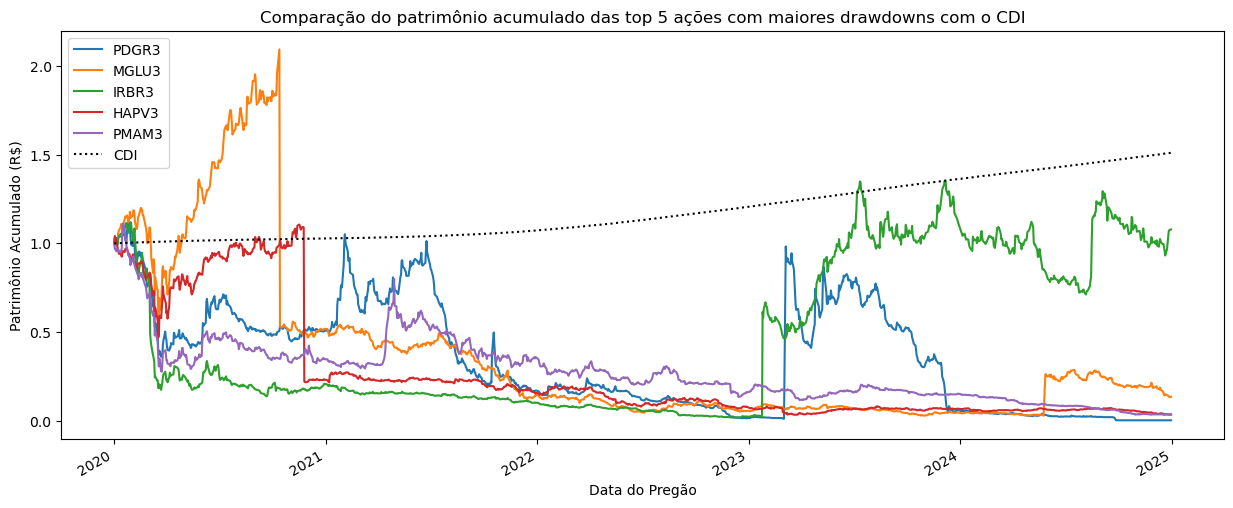

In [52]:
stocks = max_dd_top10
rk.compound(rets_5y[stocks[:5]]).plot(figsize=(15,6))
rk.compound(rets_sav).plot(style=':', c='black')
plt.legend([*stocks[:5], 'CDI'])
plt.xlabel('Data do Pregão')
plt.ylabel('Patrimônio Acumulado (R$)')
plt.title('Comparação do patrimônio acumulado das top 5 ações com maiores drawdowns com o CDI')
plt.show()

Vemos uma perda de valor significativo em relação ao CDI. O que não chega a ser tão dramático para as ações com os dez menores drawdowns:

In [53]:
min_dd_top10 = rets_5y_stats['Drawdown Máximo (%)'].sort_values(ascending=False).head(10).index
rets_5y_stats[['Drawdown Máximo (%)']].loc[min_dd_top10]

,Drawdown Máximo (%)
TAEE3,-27.89
EGIE3,-34.72
VIVT3,-35.90
ALUP3,-37.07
AGRO3,-38.06
BEES3,-39.13
EQTL3,-39.79
CPFE3,-40.58
ITUB3,-41.29
ITSA3,-43.32


No entanto os drawdowns máximos ainda são altos com perdas de até 43%. Comparando estes ativos com o CDI temos:

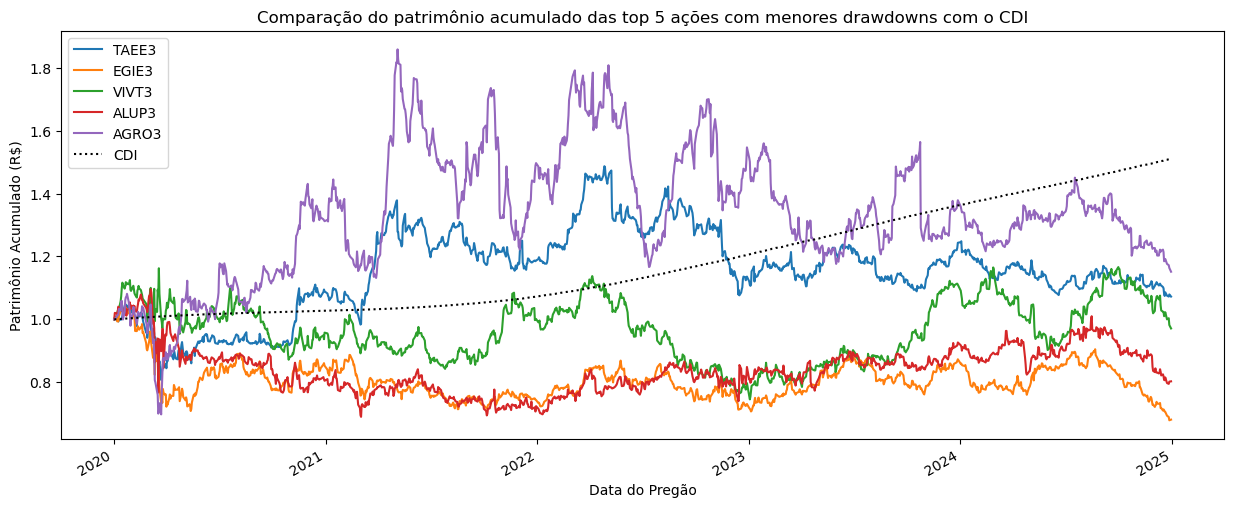

In [54]:
stocks = min_dd_top10
rk.compound(rets_5y[stocks[:5]]).plot(figsize=(15,6))
rk.compound(rets_sav).plot(style=':', c='black')
plt.legend([*stocks[:5], 'CDI'])
plt.xlabel('Data do Pregão')
plt.ylabel('Patrimônio Acumulado (R$)')
plt.title('Comparação do patrimônio acumulado das top 5 ações com menores drawdowns com o CDI')
plt.show()

O que é um comportamento melhor que antes, porém ainda temos um retorno abaixo do CDI.

#### Maiores e menores índices de Sharpe:

Em vez de analisarmos os ativos com maiores e menores retornos anualizados vamos focar em ações com maiores e menores índices de Sharpe. A razão para isto é que com este índice podemos analisar o retorno dos ativos em relação ao CDI e ao mesmo tempo capturar a sua volatilidade, tendo assim uma análise mais apurada do que somente com o retorno anualizado sem nenhuma referência para comparação.

As dez ações com menores índices de Sharpe são:

In [55]:
min_sr_top10 = rets_5y_stats['SR Anualizado'].sort_values().head(10).index
rets_5y_stats[['SR Anualizado']].loc[min_sr_top10]

,SR Anualizado
RDNI3,-1.00
QUAL3,-1.00
PMAM3,-1.00
CRFB3,-0.88
BBDC3,-0.87
COGN3,-0.86
HAPV3,-0.84
CSAN3,-0.84
CVCB3,-0.80
MEAL3,-0.80


Temos aqui ativos com retorno menor que o CDI e com um SR relativamente alto o que indica baixa volatilidade, logo seriam ações com forte e estável tendência de queda. Isto é demonstrado no gráfico abaixo:

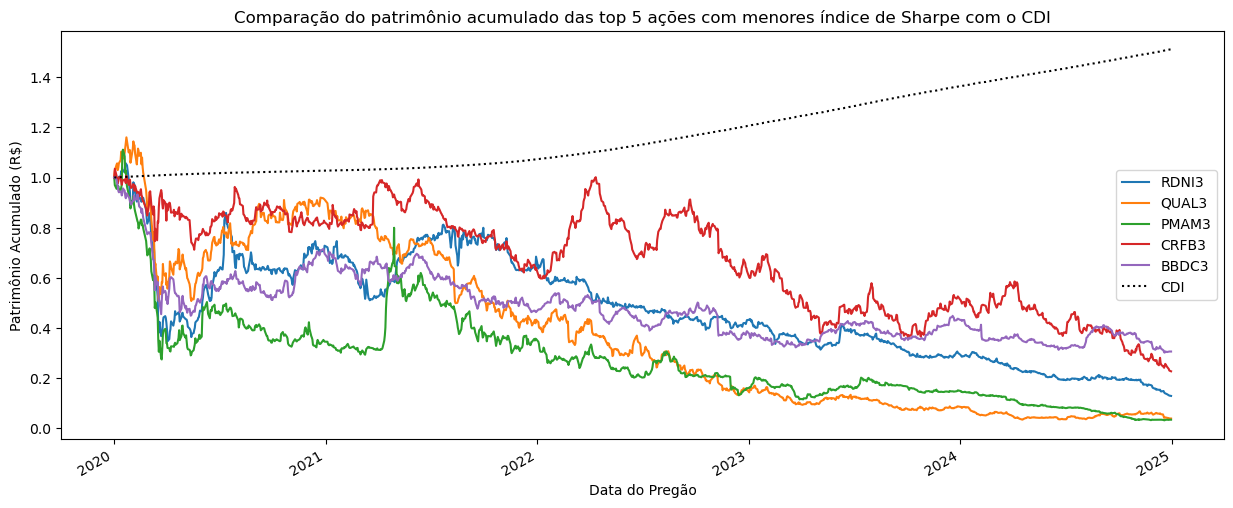

In [56]:
stocks = min_sr_top10
rk.compound(rets_5y[stocks[:5]]).plot(figsize=(15,6))
rk.compound(rets_sav).plot(style=':', c='black')
plt.legend([*stocks[:5], 'CDI'])
plt.xlabel('Data do Pregão')
plt.ylabel('Patrimônio Acumulado (R$)')
plt.title('Comparação do patrimônio acumulado das top 5 ações com menores índice de Sharpe com o CDI')
plt.show()

Já para as ações com os dez maiores SR temos:

In [57]:
max_sr_top10 = rets_5y_stats['SR Anualizado'].sort_values(ascending=False).head(10).index
rets_5y_stats[['SR Anualizado']].loc[max_sr_top10]

,SR Anualizado
FRAS3,0.54
EMBR3,0.28
RCSL3,0.12
TPIS3,0.11
VULC3,0.07
DIRR3,0.07
MRFG3,0.05
TASA3,0.04
RANI3,0.04
FHER3,0.03


Temos aqui então ações com um retorno acima do CDI, todavia, com exceção de FRAS3 e EMBR3, temos baixos índices, o que indica que apesar do retorno ser acima do CDI esses ativos tem uma alta volatilidade indicando então uma baixa estabilidade. Podemos verificar isso abaixo:

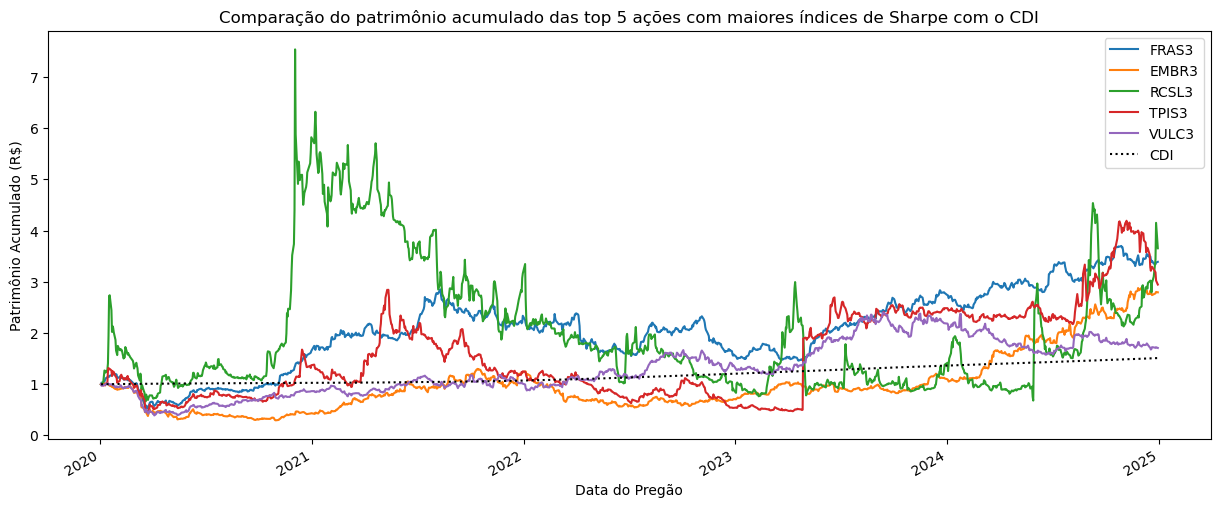

In [58]:
stocks = max_sr_top10
rk.compound(rets_5y[stocks[:5]]).plot(figsize=(15,6))
rk.compound(rets_sav).plot(style=':', c='black')
plt.legend([*stocks[:5], 'CDI'])
plt.xlabel('Data do Pregão')
plt.ylabel('Patrimônio Acumulado (R$)')
plt.title('Comparação do patrimônio acumulado das top 5 ações com maiores índices de Sharpe com o CDI')
plt.show()

Vemos que apesar de RCSL3 ter um retorno final acima de FRAS3 e EMBRA3, esta possui uma alta volatilidade e portanto acaba tendo um índice de Sharpe menor que FRAS3 e EMBRA3. Já FRAS3 e EMBRA3 demonstram um crescimento mais estável, indicado pelos seus respectivos SR que são mais altos.

#### Distribuições em relação a IS e o CDI:

Por fim podemos ver o histograma de algumas quantidades e compará-las com o nosso IS e o CDI. Temos para o retorno anualizado o seguinte histograma:

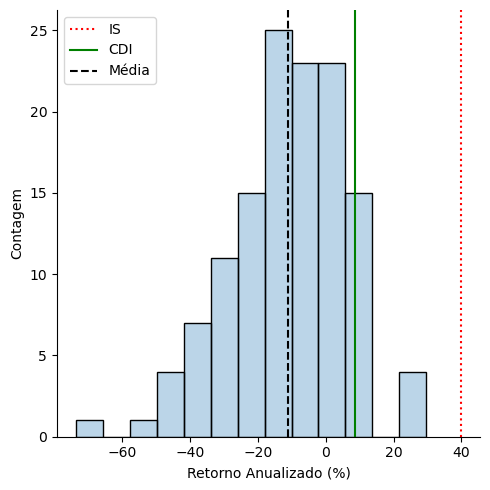

In [59]:
sns.displot(rets_5y_stats, x='Retorno Anualizado (%)', kind='hist', alpha=0.3, legend=False)
plt.axvline(x=IS_stats['Retorno Anualizado (%)'].values[0], c='red', linestyle=':')
plt.axvline(x=CDI_stats['Retorno Anualizado (%)'].values[0], c='green')
plt.axvline(x=rets_5y_stats['Retorno Anualizado (%)'].mean(), c='black', linestyle='--')
plt.ylabel('Contagem')
plt.legend(['IS', 'CDI', 'Média'])
plt.show()

Vemos que os retornos anualizados de todos os ativos estão estritamente abaixo do retorno do nosso IS e além disso estão majoritariamente abaixo do CDI. Vemos então que para um investidor atingir retornos acima do CDI, estrátegias de investimento mais complexas combinando ativos em carteiras devem ser desenvolvidas.

Vejamos agora a distribuição drawdowns máximos:

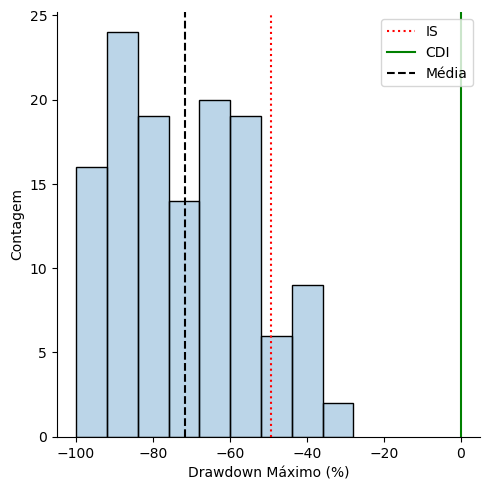

In [60]:
sns.displot(rets_5y_stats, x='Drawdown Máximo (%)', kind='hist', alpha=0.3, legend=False)
plt.axvline(x=IS_stats['Drawdown Máximo (%)'].values[0], c='red', linestyle=':')
plt.axvline(x=CDI_stats['Drawdown Máximo (%)'].values[0], c='green')
plt.axvline(x=rets_5y_stats['Drawdown Máximo (%)'].mean(), c='black', linestyle='--')
plt.ylabel('Contagem')
plt.legend(['IS', 'CDI', 'Média'])
plt.show()

Temos que a maioria das ações tem um drawdown máximo bem inferior ao drawdown do IS de -49.26%, além disso CDI possui drawdown nulo como esperado dado que todos os seus retornos são positivos. Vejamos por fim o histograma os índices de Sharpe:

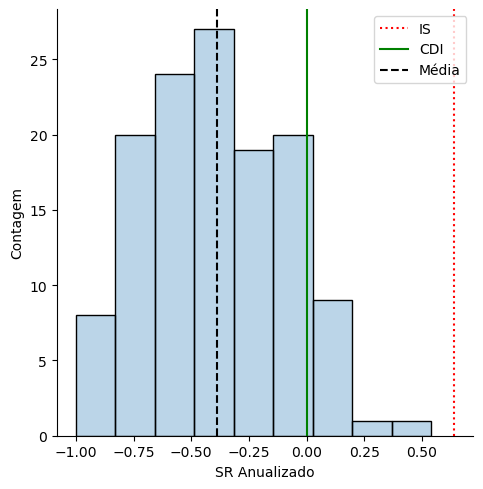

In [61]:
sns.displot(rets_5y_stats, x='SR Anualizado', kind='hist', alpha=0.3, legend=False)
plt.axvline(x=IS_stats['SR Anualizado'].values[0], c='red', linestyle=':')
plt.axvline(x=CDI_stats['SR Anualizado'].values[0], c='green')
plt.axvline(x=rets_5y_stats['SR Anualizado'].mean(), c='black', linestyle='--')
plt.ylabel('Contagem')
plt.legend(['IS', 'CDI', 'Média'])
plt.show()

Temos que a maior parte dos investimentos possui um SR negativo, o que é esperado dado que a maioria possui retorno abaixo do CDI. Além disso mesmo ativos com SR acima de zero ainda tem um índice abaixo de IS. Logo olhando para ativos individuais temos uma performance significativamente abaixo da carteira combinada de IS. Portanto vamos olhar para carteiras combinadas, pois com estas é possível reduzir a volatilidade em comparação aos ativos individuais e aumentar os retorno o que nos daria um índice de Sharpe melhor.

## Portfólios e fronteira eficiente:

Vimos que para se obter um índice de Sharpe superior e retornos maiores uma boa opção é diversificar a carteira combinando vários ativos. Façamos isso agora, seja $R$ um vetor de retornos anualizados de uma carteira com $N$ ações, $\Sigma$ a matriz de covariância destas $N$ ações e $w$ um vetor de pesos para cada ação na carteira. Logo o retorno e volatilidade de um portfólio formado combinando todas as ações é
$$
R_{pf} = w^T R 
$$
$$
\sigma_{pf} = \sqrt{w^T \Sigma w}
$$
Com os pesos satifazendo:
$$
\sum_{i=1}^{N} w_i = 1
$$
Podemos reescrever o retorno e a volatilidade da carteira em termos das componentes como:
$$
R_{pf} = \sum_{i=1}^{N} w_i R_i
$$
$$
\sigma_{pf} =  \sqrt{\sum_{i=1}^{N} w_i^2 \sigma_i^2 +  \sum_{i\neq j}^{N} w_i w_j \sigma_i \sigma_j \rho_{ij}}
$$
Com $\rho_{ij}$ sendo a matriz de correlação da carteira. Note que dada uma carteira é possível encontrar pesos $w_i$ que minimizam a volatilidade e este é o segredo por trás de diversificação. Logo através de uma escolha embasada dos pesos de cada ativo no portfólio podemos minimizar a incerteza (volatilidade) deste e manter um certo nível de retorno. Calculemos então os retornos anualizados e a matriz de covariância que usaremos:

In [62]:
er = rk.annualized_rets(rets_5y[stocks_IS], n_dates)
cov = rets_5y[stocks_IS].cov()
risk_free_rate = rk.annualized_rets(rets_sav, n_dates)

Por simplicidade nos limitamos ao conjunto de ações que formam a carteira de IS. Para calcular o a volatilidade e retornos de portfólios usaremos `portfolio_vol` e `portfolio_return`. Vamos considerar agora alguns exemplos de portfólios. O primeiro é o mais simples é o portfólio com todos os pesos iguais (portfólio EW):
$$
w_i = \frac{1}{N}.
$$
Neste caso temos (usando a função `ew`):

In [63]:
w_ew = rk.ew(er)
ew_point = rk.portfolio_vol(w_ew, cov), rk.portfolio_return(w_ew, er)
ew_point

(0.020003952400577337, -0.12862142865280007)

Com a primeira componente sendo a volatilidade e a outra o retorno. Vemos que EW não é uma estratégia ótima dado que tem um retorno anualizado negativo, contudo temos uma baixíssima volatilidade de 2%. 

Outro portfólio é dado por maximizar o índice de Sharpe (MSR), isto é,
$$
\textrm{max}_{w}\ SR_{pf}(w) \ \ \ \textrm{com} \ \ \ \sum_{i=1}^{n} w_i = 1, \ \ \ w_i \geq 0, \ \ \ \textrm{e} \ \ \ SR_{pf}(w) = \frac{w^T R - r_f}{\sqrt{w^T \Sigma w}}
$$
Aqui $r_f$ é a taxa anualizada do ativo sem risco (CDI em nosso caso) dada por `risk_free_rate` e é aproximadamente 8.6%. Os pesos são então dados pela função `msr`:

In [64]:
w_msr = rk.msr(risk_free_rate, er, cov)
msr_point = rk.portfolio_vol(w_msr, cov), rk.portfolio_return(w_msr, er)
msr_point

(0.02914571218463903, 0.22815328150137668)

Aqui temos um portfólio com baixa volatilidade de 2.91% e um bom retorno anual de 22.82%, o que é esperado dado que este portfólio é obtido por meio de maximização do SR.

Outro caso que consideraremos é o portfólio com menor variância global (GMV). Este é obtido por meio do seguinte problema de otimização:
$$
\textrm{min}_{w}\ w^T \Sigma w \ \ \ \textrm{com} \ \ \ \sum_{i=1}^{n} w_i = 1, \ \ \ w_i \geq 0
$$
Implementamos este com a função `gmv` e temos:

In [65]:
w_gmv = rk.gmv(cov)
gmv_point = rk.portfolio_vol(w_gmv, cov), rk.portfolio_return(w_gmv, er)
gmv_point

(0.009174243183023895, -0.025563237204840245)

Logo encontramos um portfólio de baxissíma volatilidade 0.98% mas com um retorno negativo de -2.56%.

Por fim podemos considerar um portfólio formado por valor de mercado (MCap) análogo ao nosso IS. Porém os pesos em nosso IS são reajustados diaramente, logo peguemos a média dos pesos ao longo do período:

In [66]:
w_mcap= w_IS.mean()
mcap_point = rk.portfolio_vol(w_mcap, cov), rk.portfolio_return(w_mcap, er)
mcap_point

(0.021742265660646017, -0.09044704156537654)

Temos então que MCap tem uma baixa volatilidade de 2.17%, contudo com um retorno anualizado de -9.04%. 

Como dito anteriormente podemos procurar portfólios que minimizem a volatilidade dado um certo retorno. A curva no espaço $(\sigma, R)$ de portfólios com minima volatilidade dado um retorno fixo é denominada de fronteira eficiente e por construção é equivalente a curva de maior índice de Sharpe dado um retorno fixo. Para construir a fronteira eficiente consideramos um retorno $R^*\in [R_{min}, R_{max}]$ com $R_{min}$ e $R_{max}$ sendo os retornos mínimo e máximo em nossa carteira. Logo um ponto $(\sigma^*, R^*)$ da fronteira eficiente é dada pelo seguinte problema de otimização:
$$
\sigma^* = \textrm{min}_{w}\ \sqrt{w^T \Sigma w} \ \ \ \textrm{com} \ \ \ \sum_{i=1}^{n} w_i = 1, \ \ \ w_i \geq 0, \ \ \ \textrm{e} \ \ \ w^T R = R^* .
$$
O que é equivalente por construção a um portfólio MSR mas com retorno excessivo fixo em $R^* - r_f$, isto é, 
$$
\textrm{max}_{w}\ SR_{pf}(w) \ \ \ \textrm{com} \ \ \ \sum_{i=1}^{n} w_i = 1, \ \ \ w_i \geq 0, \ \ \ \textrm{e} \ \ \ SR_{pf}(w) = \frac{R^* - r_f}{\sqrt{w^T \Sigma w}}
$$
Aqui implementamos a fronteira eficiente com `plot_ef`:

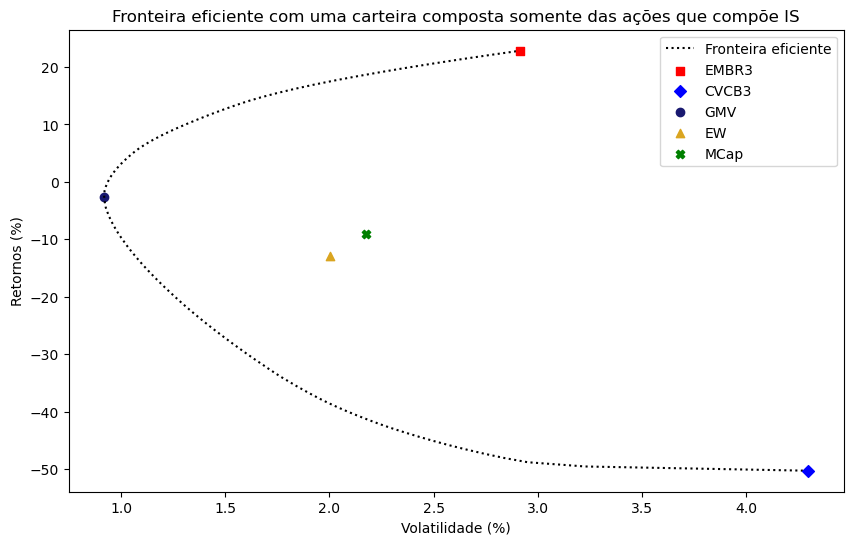

In [67]:
rk.plot_ef(n_points=100, er=er, cov=cov, figsize=(10,6), show_endpoints=True, show_gmv=True, 
           show_ew=True, show_mcap=True, w_mcap=w_mcap)
plt.title('Fronteira eficiente com uma carteira composta somente das ações que compõe IS')
plt.show()

Vemos claramente que as ações com maior e menor retorno anualizados são EMBR3 e CVCB3, respectivamente. Além disso vemos que os portfólios EW e Mcap estão longe de serem ótimos, de fato poderíamos obter portfólios com o mesmo retorno mas menor volatilidade movendo-se para a esquerda até a curva eficiente ou manteríamos a mesma volatilidade porém com maior retorno movendo para cima até a curva eficiente.

## Construção de portfólios:

Dado um conjunto de $N$ ativos (sendo ações ou renda fixa) com retornos $R_i$ vamos construir portfólios da forma:
$$
R_{pf} = \sum_{i=1}^{N} w_i R_i \ \ \ \textrm{com} \ \ \ \sum_{i=1}^{N} w_i = 1
$$
Os portfólios que consideraremos são mistura fixa, glidepath e CPPI e como benchmark usaremos o nosso IS.


### Mistura fixa:

Neste caso temos pesos $w_i$ que são fixos ao longo do tempo, ou seja, este é um portfólio de proporção fixa. Para uma combinação de dois ativos (em nosso exemplo ação + CDI) usaremos a função `fixedmix_allocator` que recebe um peso (digamos $w=$ 60%) e retorna uma lista com os pesos em cada ação. Considere EMBR3 e MGLU3 como exemplos:

In [68]:
rk.fixedmix_allocator(rets_5y[['EMBR3', 'MGLU3']], rets_sav, 0.6).head()

,EMBR3,MGLU3
DATA_DO_PREGAO,,
2020-01-02,0.6,0.6
2020-01-03,0.6,0.6
2020-01-06,0.6,0.6
2020-01-07,0.6,0.6
2020-01-08,0.6,0.6


Vemos então que os pesos são constantes ao longo do tempo. A seguir usamos então a função `pf_mix` para combinar as duas ações acima com o CDI (ativo sem risco). Neste caso o investidor espera aproveitar o risco e o potencial ganho da ação ao mesmo tempo que garante um investimento seguro de parte do portfólio em renda fixa. Então obtemos para o patrimônio acumulados ao longo do tempo:

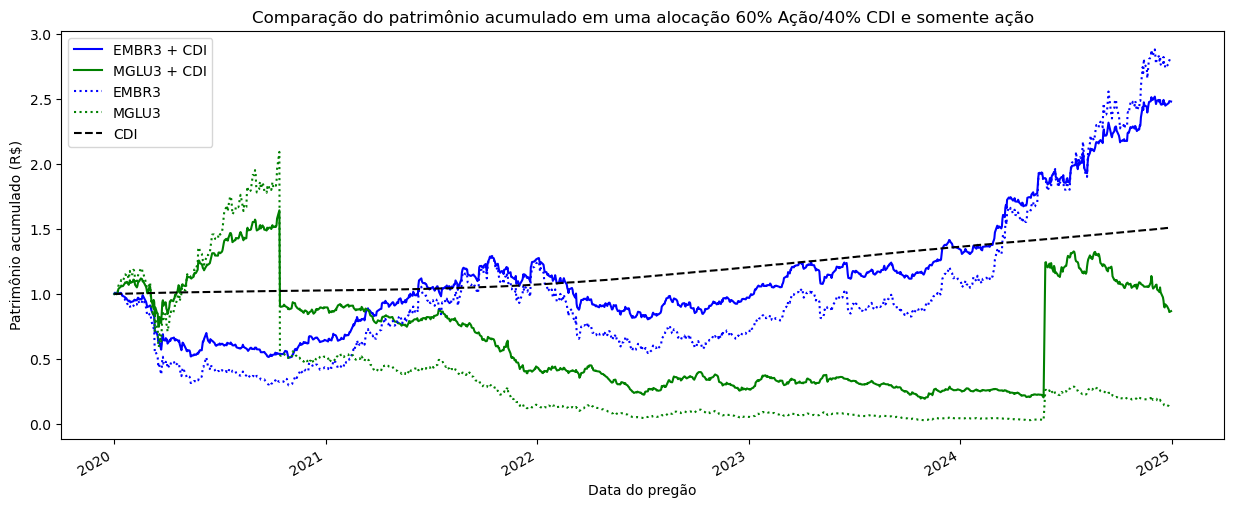

In [69]:
rets_plot = rk.pf_mix(r1=rets_5y[['EMBR3', 'MGLU3']], r2=rets_sav, allocator=rk.fixedmix_allocator, w1=0.6)

ax = rk.compound(rets_plot).plot(figsize=(15,6), color=['blue', 'green'])
rk.compound(rets_5y[['EMBR3', 'MGLU3']]).plot(ax=ax, style=':', color=['blue', 'green'])
rk.compound(rets_sav).plot(ax=ax, style='--k')

plt.title('Comparação do patrimônio acumulado em uma alocação 60% Ação/40% CDI e somente ação')
plt.xlabel('Data do pregão')
plt.ylabel('Patrimônio acumulado (R$)')
plt.legend(['EMBR3 + CDI', 'MGLU3 + CDI', 'EMBR3', 'MGLU3', 'CDI'])
plt.show()

Note que em períodos de alta (como ocorre com EMBR3 no final do período considerado) temos que o rendimento de ação + CDI é menor que só a ação pois a alocação fixa em CDI puxa para baixo o rendimento. Do outro lado temos que em períodos de perdas consideráveis (como ocorre com MGLU3) seria mais favorável alocar majoritariamente em CDI. Este é o ponto fraco de uma alocação fixa, ela não permite um uso mais favorável das condições atuais de mercado na alocação do portfólio pois estamos sempre presos a uma alocação constante definida no passado.

Podemos ir além e considerar um portfólio formado somente por uma combinação de ativos com risco, a ideia é combinar os portfólios de tal maneira que tenhamos uma redução na volatilidade e um possível aumento no retorno como discutido na seção anterior (ver *Portfólios e fronteira eficiente*). Consideraremos os portfólios EW (pesos iguais), MSR (índice de Sharpe máximo) e GMV (variância global mínima) construídos somente com os ativos presentes em nosso índice IS. Para a alocação nestes portfólios usamos a função `fixed_weights_mix`:

In [70]:
# portfólio ew
rets_ew = rk.fixed_weights_mix(rets_5y[stocks_IS], w_ew, 'EW')
# portfólio msr
rets_msr = rk.fixed_weights_mix(rets_5y[stocks_IS], w_gmv, 'GMV')
# portfólio gmv
rets_gmv = rk.fixed_weights_mix(rets_5y[stocks_IS], w_msr, 'MSR')
# dataframe contendo todos os portfólios acima + IS + CDI
rets_pfs = pd.DataFrame([rets_ew, rets_msr, rets_gmv, rets_IS, rets_sav]).T

Podemos então comparar o patrimônio acumulado em cada portfólio:

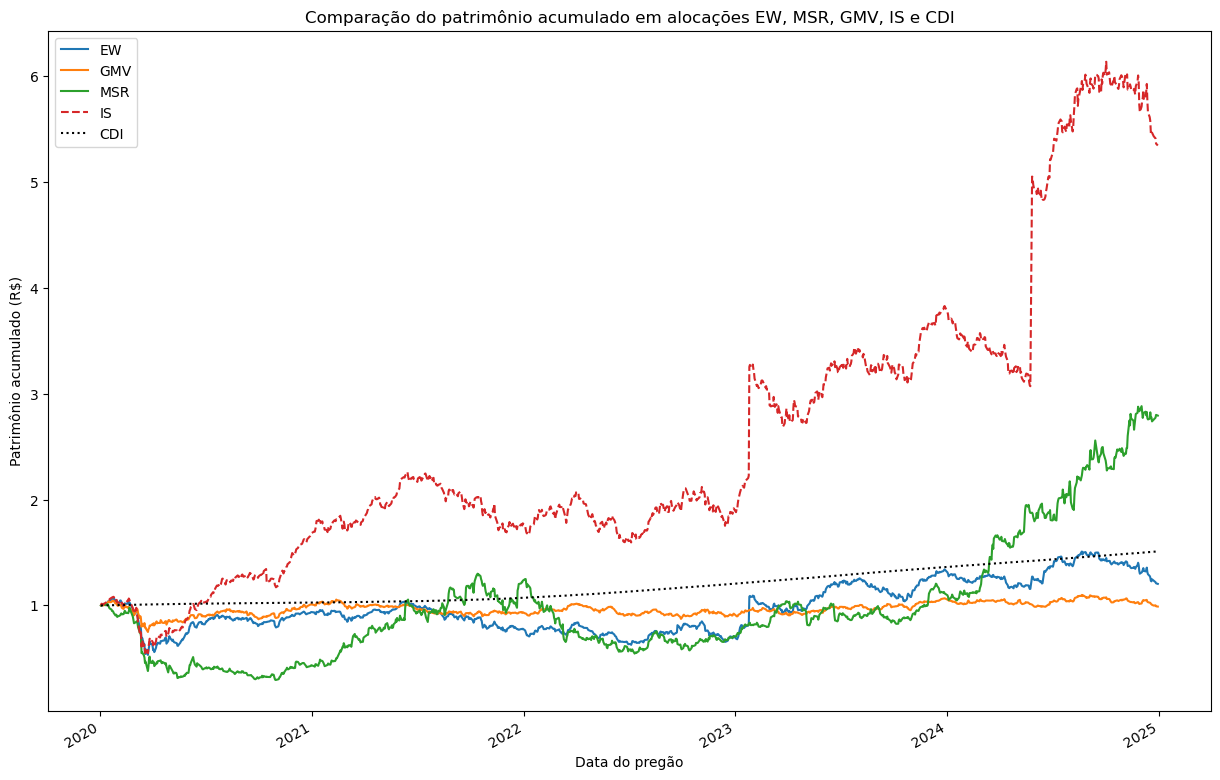

In [71]:
rk.compound(rets_pfs).plot(figsize=(15,10), legend=True, 
                           style=['-', '-', '-', '--', ':k'])

plt.title('Comparação do patrimônio acumulado em alocações EW, MSR, GMV, IS e CDI')
plt.xlabel('Data do pregão')
plt.ylabel('Patrimônio acumulado (R$)')
plt.show()

Vemos que o nosso IS performa significativamente acima dos demais portfólios, mesmo acima do portfólio MSR. Um motivo para isso pode ser a alocação dinâmica que realizamos para construir IS baseado em volume de mercado, provavelmente o que ocorre é que ações com performances melhores são mais negociadas e portanto acabam tendo um peso maior em nosso portfólio. Abaixo temos as estatísticas agregadas destes portfólios:

In [72]:
rk.summary_stats(rets_pfs, n_dates, rets_sav)

,Retorno Anualizado (%),Volatilidade Anualizada (%),SR Anualizado,Drawdown Máximo (%),Assimetria,Curtose,VaR Histórico (%),CVaR Histórico (%)
EW,3.78,31.57,-0.14,-50.29,3.12,68.98,-2.34,-3.99
GMV,-0.21,14.48,-0.56,-28.37,-0.89,12.45,-1.33,-2.17
MSR,22.82,45.99,0.28,-70.86,0.01,10.47,-4.05,-6.35
IS,39.83,44.83,0.64,-49.26,12.42,269.25,-2.33,-4.17
CDI,8.60,0.27,0.00,0.00,-0.32,1.90,0.01,0.01


Vemos que somente MSR e IS possuem um rendimento anual acima do CDI, contudo a volatilidade de MSR é alta e pode afastar investidores mais conservadores. De fato chegamos a ter um drawdown alto de -70.86% para este portfólio. Vemos também que comparando somente alocações fixas (EW, GMV, MSR) temos que MSR e GMV atingiram os seus objetivos de maximização do índice de Sharpe e minimização da volatilidade, respectivamente.

### Glidepath:

Neste caso consideramos um portfólio com dois ativos e os pesos são dinâmicos. A ideia é que começamos com uma alocação fixa digamos $(w_1^{(0)}, w_2^{(0)})$ e nos movemos em uma taxa constante para uma alocação $(w_1^{(f)}, w_2^{(f)})$. Logo, dado um período com o número de dias de pregão $N_{d}$ temos que no dia $i$ os pesos são:
$$
w_1^{(i)} = \left( 1 - \frac{i}{N_{d}} \right) w_1^{(0)} + w_1^{(f)} \ \ \ \textrm{e} \ \ \ w_2^{(i)} = 1 - w_1^{(i)}
$$
A ideia por trás disso é investir em uma combinação de uma ação+CDI com uma proporção inicial maior na ação e gradualmente mover o nosso portfólio em direção a uma proporção maior do CDI, pois temos um incerteza maior dos retornos a longo prazo que a curto prazo e assim teríamos uma segurança garantida a longo prazo ao mesmo tempo que aproveitamos o ativo com risco a curto prazo. Estra estratégia é denominada glidepath e é implementada por `glidepath_allocation`. Consideraremos novamente como exemplo EMBR3 e MGLU3:

In [73]:
rk.glidepath_allocation(rets_5y[['EMBR3', 'MGLU3']], rets_sav)

,EMBR3,MGLU3
DATA_DO_PREGAO,,
2020-01-02,1.000000,1.000000
2020-01-03,0.999196,0.999196
2020-01-06,0.998392,0.998392
2020-01-07,0.997588,0.997588
2020-01-08,0.996785,0.996785
...,...,...
2024-12-20,0.003215,0.003215
2024-12-23,0.002412,0.002412
2024-12-26,0.001608,0.001608


Neste caso começamos com uma alocação 100% ação e nos movemos em direção ao CDI a uma taxa fixa tal que no fim do período alocamos o nosso portfólio totalmente em CDI. Vejamos o efeito dessa estratégia no patrimônio acumulado:

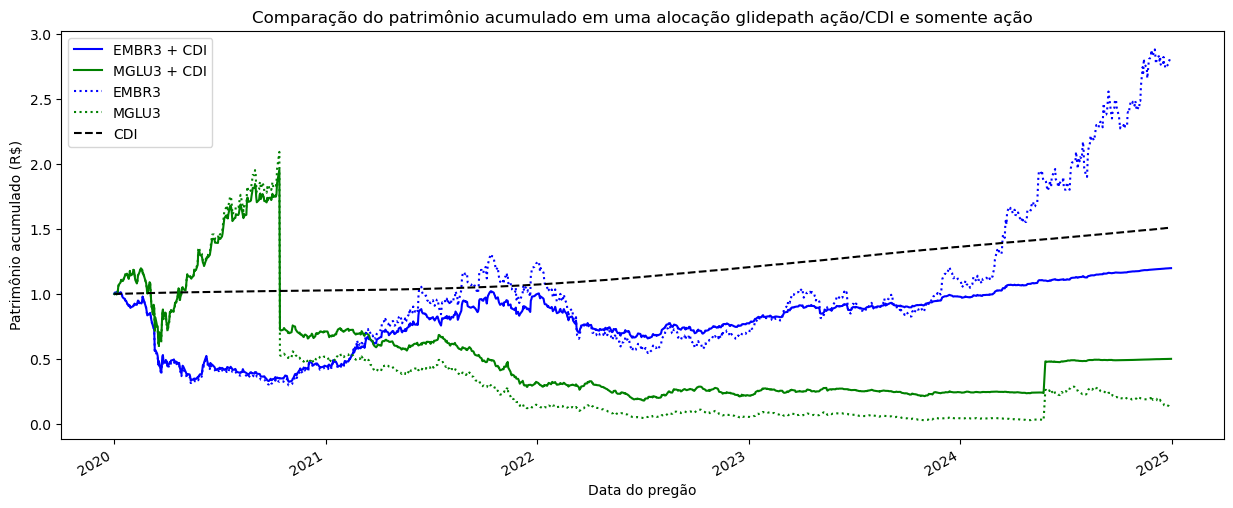

In [74]:
rets_plot = rk.pf_mix(r1=rets_5y[['EMBR3', 'MGLU3']], r2=rets_sav, allocator=rk.glidepath_allocation)

ax = rk.compound(rets_plot).plot(figsize=(15,6), color=['blue', 'green'])
rk.compound(rets_5y[['EMBR3', 'MGLU3']]).plot(ax=ax, style=':', color=['blue', 'green'])
rk.compound(rets_sav).plot(ax=ax, style='--k')

plt.title('Comparação do patrimônio acumulado em uma alocação glidepath ação/CDI e somente ação')
plt.xlabel('Data do pregão')
plt.ylabel('Patrimônio acumulado (R$)')
plt.legend(['EMBR3 + CDI', 'MGLU3 + CDI', 'EMBR3', 'MGLU3', 'CDI'])
plt.show()

Vemos claramente que a príncipio a ação e o glidepath se sobrepõem, contudo com o passar do tempo começamos a ter uma volatilidade menor pois a alocação passa a ser majoritária no CDI. O benefício desta estratégia é a garantia de estabilidade futura, contudo caso tenhamos uma queda no começo que não possa ser recuperada ao longo do tempo somente com a renda fixa temos uma perda de patrimônio mesmo que a ação cresça consideralmente como no caso de EMBR3.

### CPPI:

O objetivo principal por trás de diversificação é a diminuição da volatilidade do portfólio com um possível aumento no retorno, como vimos anteriormente com a fronteira eficiente. Temos no entanto que há um limite no quanto a diversificação pode reduzir a volatilidade. Considere como exemplo dois ativos com retornos anuais de 10% e -26% e volatilidades de 15% e 25%, respectivamente, e a seguinte matriz de covariância:
$$
\Sigma = 
\begin{pmatrix}
\sigma_1^2 & \sigma_1 \sigma_2 \ \rho \\
\sigma_1 \sigma_2 \ \rho & \sigma_2^2 
\end{pmatrix}
$$
Com $\rho$ sendo a correlação entre os ativos. Podemos ver então como a fronteira eficiente varia com a correlação:

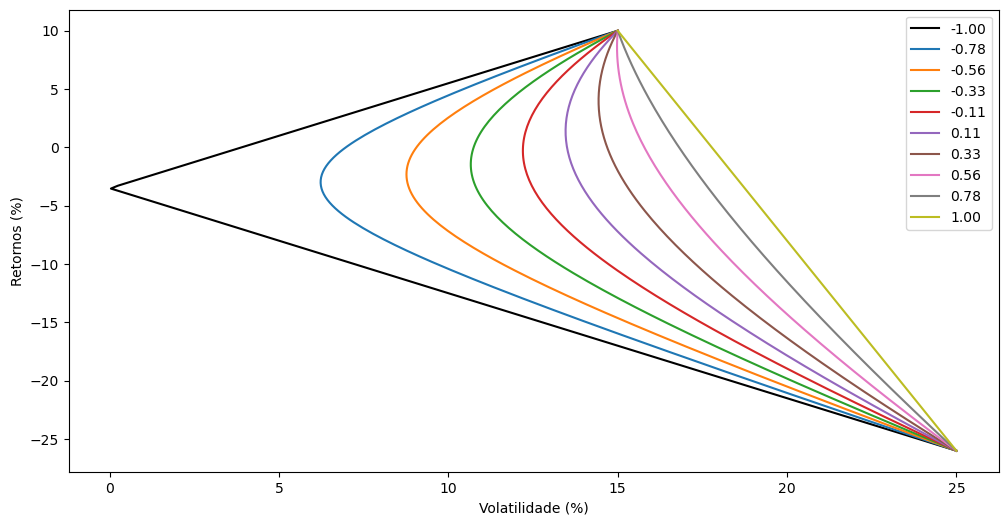

In [75]:
# retornos 
er = pd.Series({'asset1': 0.1, 'asset2': -.26})
# matrix de covariancia em funcao da correlacao
sigma1, sigma2 = 0.15, 0.25
def cov_ex(rho):
    return pd.DataFrame({'asset1': [sigma1**2, sigma1*sigma2*rho], 'asset2': [sigma1*sigma2*rho, sigma2**2]}, 
                        index=['asset1', 'asset2'])
# plot fronteira eficiente em funcao de rho
rk.plot_ef_multiple(10, 150, er, cov_ex)
plt.show()

Vemos que conforme a correlação aumenta, a volatilidade do ponto de variância global mínima (GMV) aumenta também. De fato, no caso de correlação máxima ($\rho=1$) temos que a volatilidade é uma média ponderada das volatilidades de cada ativo (representada pela reta no plot acima) e portanto não podemos diminuir a volatilidade abaixo da menor volatilidade entre os dois ativos. 

Dado isso temos um problema na prática. Note que é interessante reduzir a volatilidade em tempos de queda, porém é justamente nestes períodos que a correlação entre ativos cresce. Por exemplo, considere PETR3 e VALE3. A correlação entre as duas séries de retornos no período 2020-2024 é 41.7%:

In [76]:
rets_5y['PETR3'].corr(rets_5y['VALE3'])*100

41.69925577495878

Temos que PETR3 tem um drawdown máximo em 18 de março de 2020:

In [77]:
rk.drawdown(rets_5y['PETR3'])['Drawdowns'].idxmin()

Timestamp('2020-03-18 00:00:00')

Porém neste mês a correlação entre esses dois ativos aumenta para 85.56%:

In [78]:
rets_5y['PETR3']['2020-03'].corr(rets_5y['VALE3']['2020-03'])*100

85.5553116535567

O mesmo é válido para VALE3, considere o drawdown máximo desta que ocorreu em 19 de Dezembro de 2024:

In [79]:
rk.drawdown(rets_5y['VALE3'])['Drawdowns'].idxmin()

Timestamp('2024-12-19 00:00:00')

A correlação entre as séries também aumenta em Dezembro de 2024 para 68.91%:

In [80]:
rets_5y['PETR3']['2024-12'].corr(rets_5y['VALE3']['2024-12'])*100

68.90701422134197

Logo precisamos de uma estratégia melhor que consiga nos prevenir contra quedas quando diversificação pura e simples falha. Com isso em mente usaremos a estratégia CPPI (*constant proportion portfolio insurance*), a idéia é que realizar um aporte dinâmico entre um ativo com risco e um sem risco de maneira a mitigarmos quedas abaixo de um piso pré-estabelecido. Vamos descrevê-lo agora. 

Seja $V_t$ o valor do patrimônio atual, $F$ um piso pré-determinado que estabelecemos e $m$ uma fator de investimento que determina o quanto colocamos em nosso ativo com risco. No tempo $t$ definimos o gap $C_t$ como a diferença proporcional entre o piso e o valor da conta: 
$$
C_t = \frac{V_t - F}{V_t}
$$
Com isso definimos:
$$
r_t = m\ C_t
$$
que seria a proporção da carteira que investiriamos no ativo com risco. Todavia queremos que essa alocação seja positiva e não emprestamos para investir nesse ativo (investimos no máximo a nossa carteira), com isso temos então:
$$
r_t = \max (\min (m\ C_t, 1), 0)
$$
Isso garante que $0 \leq r_t \leq 1$. Logo a quantidade que investimos no ativo com risco, denotado por $S_t$ e no ativo sem risco, denotado por $B_t$, é:
$$
S_{t} = r_t V_t \ \ \ \textrm{e} \ \ \ B_{t} = (1-r_t) V_t.
$$
Seja $R^{(S)}_t$ and $R^{(B)}_t$ os retornos dos ativos com e sem risco no tempo $t$, respectivamente, temos que o valor do portfólio CPPI no tempo $t+1$ é dado por:
$$
V_{t+1} = S_t \ (1+R^{(S)}_t) + B_t \ (1+R^{(B)}_t)
$$
Considere por exemplo um piso de 75%, o que CPPI busca garantir é um portfólio com alocação dinâmica que nunca ultrapasse este piso. Note que isso só é possível quando não temos quedas muito abruptas. Nos implementamos e plotamos CPPI com a funções `run_cppi` e `plot_cppi`. Como exemplo, considere um portfólio CPPI com $m=3$ e piso de 75% com uma combinação de PETR3 e CDI:

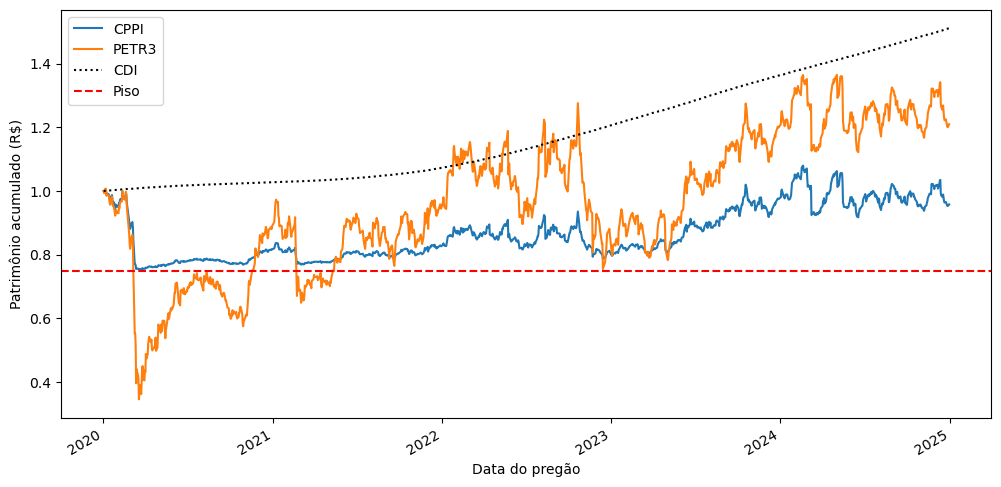

In [81]:
CPPI = rk.run_cppi(rets_5y['PETR3'], rets_sav, m=3, floor=0.75)
rk.plot_cppi(CPPI, rets_sav, stock_name='PETR3')

Vemos que CPPI cumpriu o seu objetivo em mitigar a queda para nunca ultrapassarmos o piso de 75%. No entanto comparando com PETR3 sem CPPI vemos, no final do período considerado, que o fato de investirmos uma proporção fixa limita os ganhos que teriamos investindo somente na ação. Vejamos como os pesos variam com o tempo:

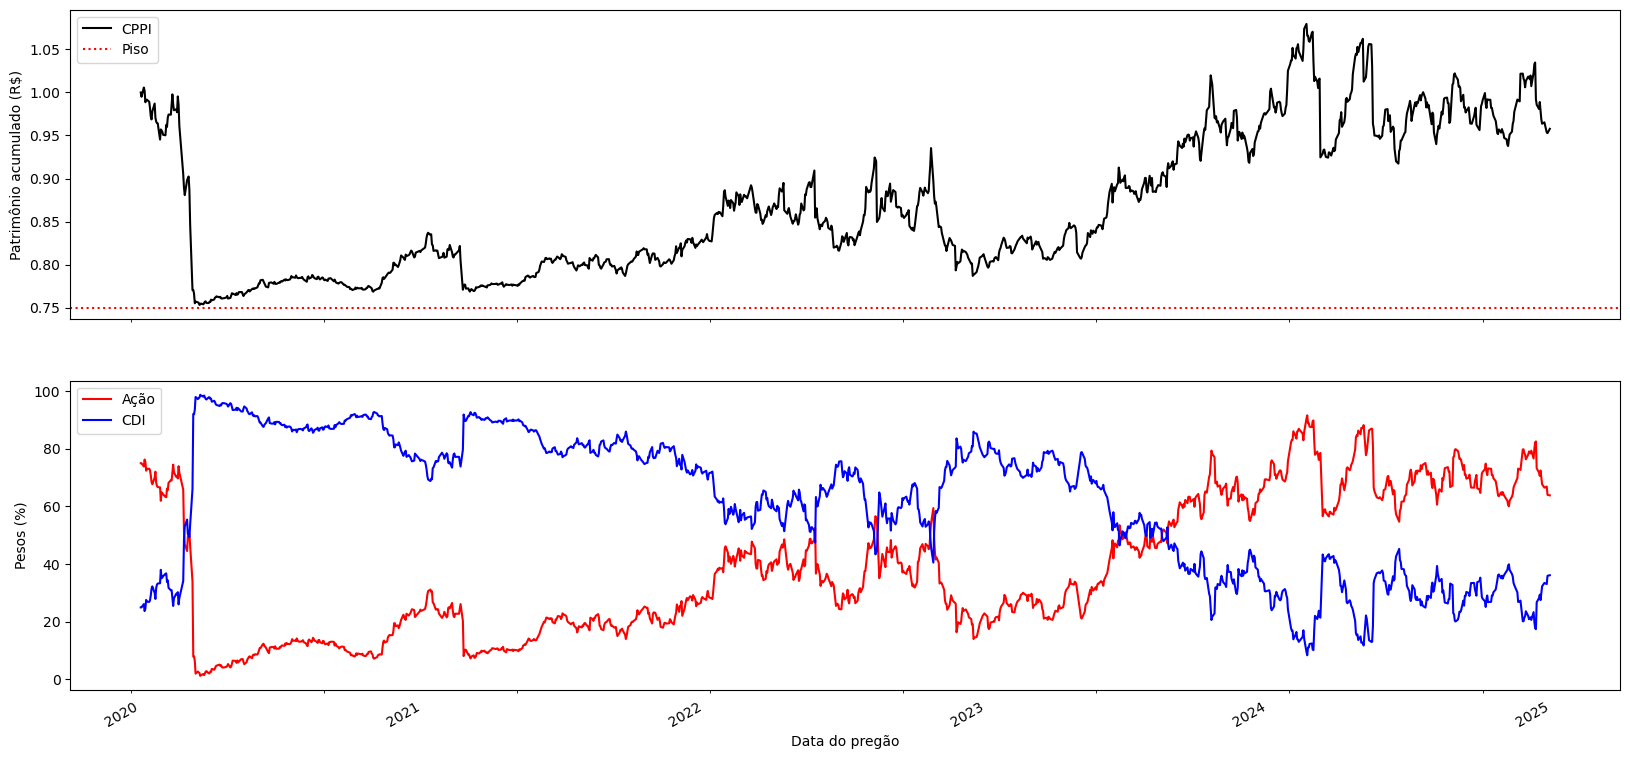

In [82]:
rk.plot_allocation(CPPI)

No gráfico inferior vemos que conforme nos aproximamos do piso o algoritmo CPPI passa a alocar majoritariamente no ativo sem risco e então conforme nos afastamos do piso o investimento passa a ser majoritário no ativo com risco. Consideremos agora o CPPI anterior, mas com uma alocação mais agressiva com $m=6$:

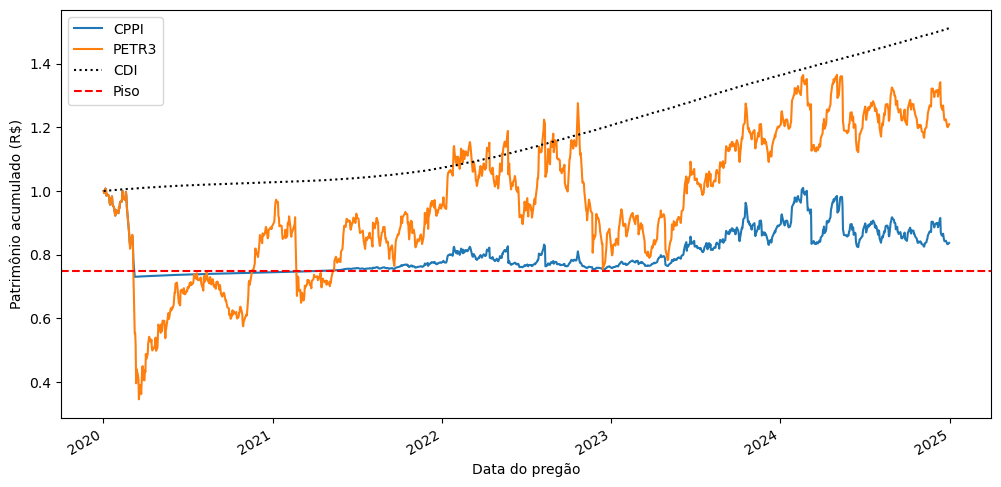

In [83]:
CPPI = rk.run_cppi(rets_5y[['PETR3']], rets_sav, m=6, floor=0.75)
rk.plot_cppi(CPPI, rets_sav, stock_name='PETR3')

Vemos agora uma violação do nosso piso de 75% pois temos uma queda muito abrupta junto com uma alocação agressiva. Note que ao passarmos o piso CPPI investe toda a carteira no ativo sem risco:

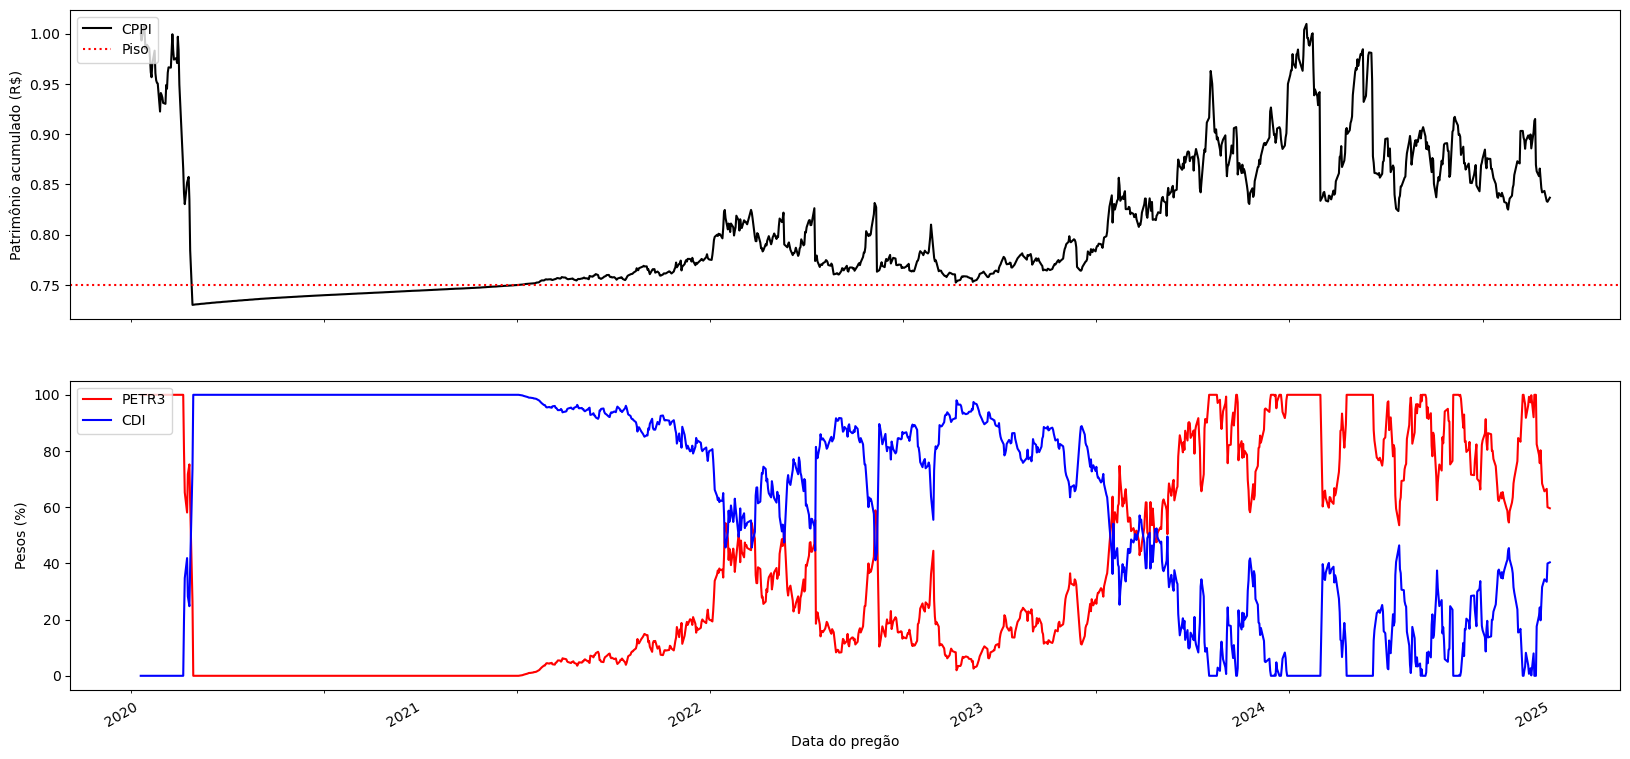

In [84]:
rk.plot_allocation(CPPI, stock_name='PETR3')

Neste caso temos que a violação do piso é baixa o suficiente para que só alocação em CDI seja o suficiente para mitigá-la. No entanto isso nem sempre ocorre, considere um CPPI com MGLU3, $m=3$ e um piso de 75%:

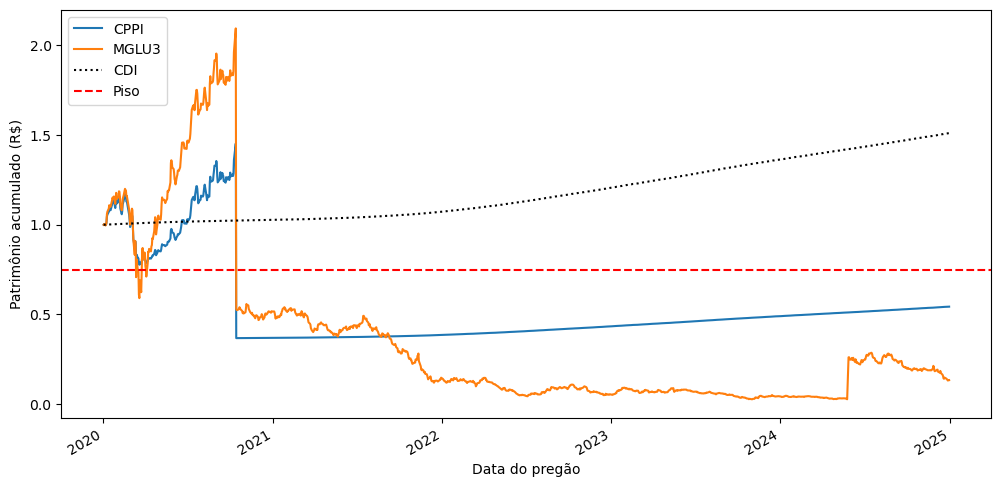

In [85]:
CPPI = rk.run_cppi(rets_5y['MGLU3'], rets_sav, m=3, floor=0.75)
rk.plot_cppi(CPPI, rets_sav, stock_name='MGLU3')

Assim como antes vemos que ao passar o piso a alocação passa a ser integral no CDI, contudo a queda foi tão abrupta que não podemos mitigá-la somente com a renda fixa. Para resolver isso modifica-se o CPPI para incluir um drawdown máximo (MaxDD CPPI). O algoritmo de MaxDD CPPI é exatamente como antes, porém agora o piso $F$ é um piso dinâmico $F_t$. Seja $P_t$ o maior pico histórico do valor da carteira $V_t$, logo:
$$
P_t = \max(P_{t-1}, V_t) \ \ \ \textrm{com} \ \ \ P_0 = V_0.
$$ 
Então dado um drawdown máximo $0 <  D < 1$ definimos o piso dinâmico como
$$
F_t = (1-D)\ P_t
$$ 
E o resto do algoritmo CPPI segue como antes. Implementamos MaxDD CPPI com `run_cppi` porém agora com a kwarg `drawdown` denotando o drawdown máximo. Novamente consideramos MGLU3 mas agora com MaxDD CPPI com $m=3$ e $D=15\%$:

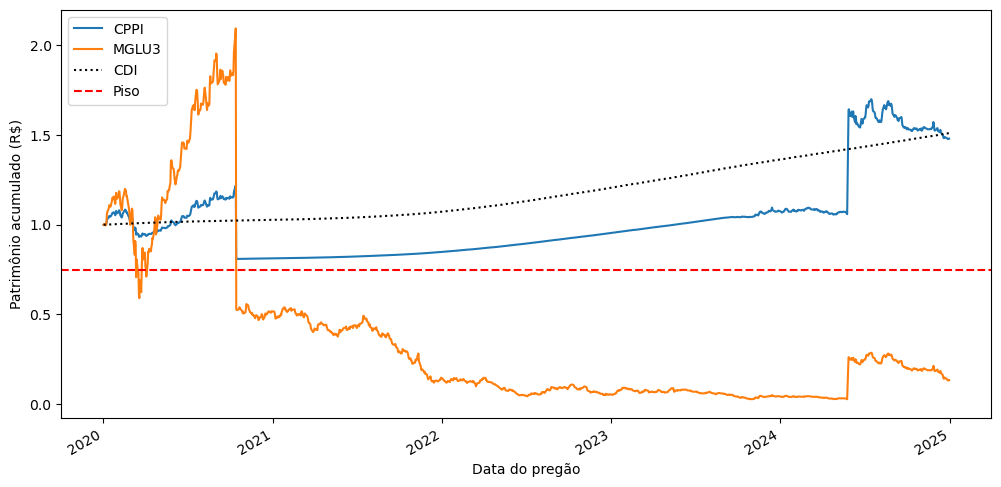

In [86]:
CPPI = rk.run_cppi(rets_5y['MGLU3'], rets_sav, floor=0.75, m=3, drawdown=0.15)
rk.plot_cppi(CPPI, rets_sav, stock_name='MGLU3')

Temos agora que um piso fixo de 75% não é violado e além disso mesmo com um ativo que sozinho possui um retorno negativo (de -86.61%) conseguimos um portfólio com retorno positivo de 47.96%! Isso é possível devido ao drawdown máximo imposto e o seu piso dinâmico, vejamos como foi realizada a determinação dos pesos:

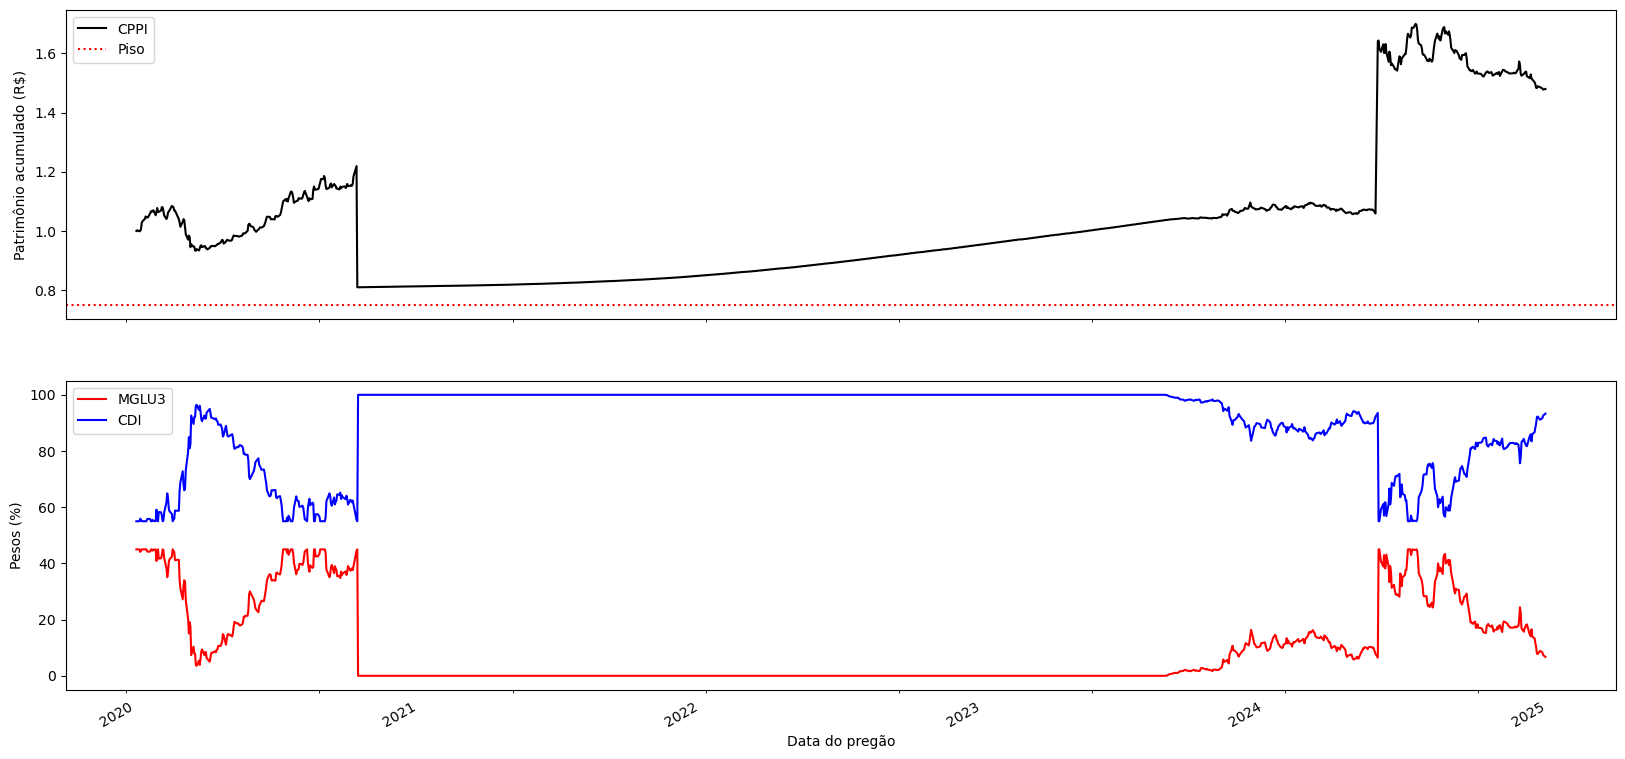

In [87]:
rk.plot_allocation(CPPI, stock_name='MGLU3')

Vemos que quando ocorre um grande drawdown toda a alocacão é realizada no CDI e só quando MGLU3 passa a ter retornos positivos podemos fazer uma alocação neste ativo.

## Perspectivas:

Neste notebook fizemos uma análise de risco do universo de ações ordinárias no período 2020-2024, discutimos os conceitos de drawdown, índice de Sharpe, valor em risco e valor em risco condicional. Além disso analisamos também a construção de portfólios usando pesos fixos (EW, GMV e MSR) além de uma alocação dinâmica com o algoritmo CPPI. Para melhorar a análise aqui proposta sugerimos:
- **Aumentar o volume de dados:** Aqui consideramos somente ações ordinárias (código XXXX3), poderíamos incluir também na análise ações preferenciais (código XXXX4), ações preferenciais de classes A e B (códigos XXXX5 e XXXX6), BDRs, ETFs, fundos de investimentos, entre outros. Além disso poderíamos considerar também outros tipos de renda fixa como CDBs que pagam uma porcentagem maior do CDI, Tesouro Direto, LCI e LCA, etc. Isso adicionaria uma nuance em nossa análise além da possibilidade de formar portfólios mais diversificados e complexos. 
- **Estimar retornos e volatilidades:** Aqui fizemos um exercício in-sample no qual criamos portfólios com base nos retornos e volatilidades históricos. Poderíamos usar outros métodos para estimar volatilidade, como por exemplo ARCH e GARCH, correlação constante, factor models e shrinkage. Também poderíamos estimar retornos usando técnicas como factor models ou análise de Black-Litterman. Isso pode ser útil pois estimativas históricas de retornos esperados podem ser superestimados devido a alta volatilidade, além disso estas são fortemente dependentes da amostra.
- **Uso de outros modelos para formação de portfólios:** Poderíamos realizar uma análise de fatores (Fama-French) e utilizarmos modelos de factor investing.